In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity, adjust_gamma
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

Setting environment for Precision WorkStation


No vtk
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
stack = 'MD662'

In [ ]:
# convert_frame_and_resolution(np.array([[1000, 400, 279], [1000, 401, 279]]), 
#                              in_wrt='alignedPadded', 
#                              in_resolution='image_image_section', 
#                              out_wrt='raw', 
#                              out_resolution='image_image_section',
#                              in_image_resolution='down32',
#                              out_image_resolution='down32',
#                             stack=stack)

In [ ]:
# for section in set(metadata_cache['valid_sections_all'][stack]) - set(metadata_cache['valid_sections'][stack]):
for section in metadata_cache['valid_sections'][stack]:
    
    print "Section", section
    
    t = time.time()
    
    img = DataManager.load_image_v2(stack=stack, prep_id=None, section=section, version='Ntb', resol='raw')

    sys.stderr.write('Load image: %.2f seconds.\n' % (time.time() - t))

    t = time.time()
    tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=None, section=section)
#     raw_mask = rescale_by_resampling(tb_mask, new_shape=(img.shape[1], img.shape[0]))
    raw_mask = resize(tb_mask, img.shape) > .5
    
    save_data(raw_mask, 
          DataManager.get_image_filepath_v2(stack=stack, prep_id=None, section=section, version='mask', resol='raw', ext='bp'), 
          upload_s3=False)
    
    sys.stderr.write('Rescale mask: %.2f seconds.\n' % (time.time() - t))

    t = time.time()
    
    mean_std_all_regions = []
    cx_cy_all_regions = []
    region_size = 5000
    region_spacing = 3000
#     for cx in range(region_size/2, img.shape[1]-region_size/2+1, region_spacing):
#         for cy in range(region_size/2, img.shape[0]-region_size/2+1, region_spacing):
    for cx in range(0, img.shape[1], region_spacing):
        for cy in range(0, img.shape[0], region_spacing):
            region = img[max(cy-region_size/2, 0):min(cy+region_size/2+1, img.shape[0]-1), 
                         max(cx-region_size/2, 0):min(cx+region_size/2+1, img.shape[1]-1)]
            region_mask = raw_mask[max(cy-region_size/2, 0):min(cy+region_size/2+1, img.shape[0]-1), 
                                   max(cx-region_size/2, 0):min(cx+region_size/2+1, img.shape[1]-1)]
            if np.count_nonzero(region_mask) == 0:
                continue
            mean_std_all_regions.append((region[region_mask].mean(), region[region_mask].std()))
            cx_cy_all_regions.append((cx, cy))
            
    sys.stderr.write('Compute mean/std for sample regions: %.2f seconds.\n' % (time.time() - t))
    
    t = time.time()
    mean_map = resample_scoremap(sparse_scores=np.array(mean_std_all_regions)[:,0], 
                             sample_locations=cx_cy_all_regions,
                             gridspec=(region_size, region_spacing, img.shape[1], img.shape[0], (0,0)),
                            downscale=4, 
                                 interpolation_order=2)

    sys.stderr.write('Interpolate mean map: %.2f seconds.\n' % (time.time() - t)) #10s

    t = time.time()
    mean_map = rescale_by_resampling(mean_map, new_shape=(img.shape[1], img.shape[0]))
    sys.stderr.write('Scale up mean map: %.2f seconds.\n' % (time.time() - t)) #30s

    t = time.time()
    std_map = resample_scoremap(sparse_scores=np.array(mean_std_all_regions)[:,1], 
                             sample_locations=cx_cy_all_regions,
                             gridspec=(region_size, region_spacing, img.shape[1], img.shape[0], (0,0)),
                            downscale=4,
                               interpolation_order=2)
    sys.stderr.write('Interpolate std map: %.2f seconds.\n' % (time.time() - t)) #10s

    t = time.time()
    std_map = rescale_by_resampling(std_map, new_shape=(img.shape[1], img.shape[0]))
    sys.stderr.write('Scale up std map: %.2f seconds.\n' % (time.time() - t)) #30s
    
    # Save mean/std results.
    
    fp = DataManager.get_intensity_normalization_result_filepath(what='region_centers', stack=stack, section=section)
    create_parent_dir_if_not_exists(fp)    
    np.savetxt(fp, cx_cy_all_regions)
    
    fp = DataManager.get_intensity_normalization_result_filepath(what='mean_std_all_regions', stack=stack, section=section)
    create_parent_dir_if_not_exists(fp)
    np.savetxt(fp, mean_std_all_regions)
    
    fp = DataManager.get_intensity_normalization_result_filepath(what='mean_map', stack=stack, section=section)
    create_parent_dir_if_not_exists(fp)
    bp.pack_ndarray_file(mean_map.astype(np.float16), fp)
    
    fp = DataManager.get_intensity_normalization_result_filepath(what='std_map', stack=stack, section=section)
    create_parent_dir_if_not_exists(fp)
    bp.pack_ndarray_file(std_map.astype(np.float16), fp)

    # Export normalized image.
    
    t = time.time()
    raw_mask = raw_mask & (std_map > 0)
    img_normalized = np.zeros(img.shape, np.float32)
    img_normalized[raw_mask] = (img[raw_mask] - mean_map[raw_mask]) / std_map[raw_mask]
    sys.stderr.write('Normalize: %.2f seconds.\n' % (time.time() - t)) #30s

    t = time.time()
    # FIX THIS! THIS only save uint16, not float16. Need to save as bp instead.
#     img_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, version='NtbNormalizedFloat', resol='down8', section=section, )
#     create_parent_dir_if_not_exists(img_fp)
#     imsave(img_fp, img_normalized[::8, ::8].astype(np.float16))
    save_data(img_normalized.astype(np.float16), 
              DataManager.get_intensity_normalization_result_filepath(what='normalized_float_map', stack=stack, section=section),
             upload_s3=False)
    sys.stderr.write('Save float version: %.2f seconds.\n' % (time.time() - t)) #30s
        
#     t = time.time()
#     img_normalized_uint8 = rescale_intensity_v2(img_normalized, -1, 6)
#     sys.stderr.write('Rescale to uint8: %.2f seconds.\n' % (time.time() - t)) #30s
    
#     t = time.time()
#     img_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, version='NtbNormalized', resol='raw', section=section)
#     create_parent_dir_if_not_exists(img_fp)
#     imsave(img_fp, img_normalized_uint8)
#     sys.stderr.write('Save uint8 version: %.2f seconds.\n' % (time.time() - t)) #30s
    
    # Export histogram.
    
    plt.hist(img_normalized[raw_mask].flatten(), bins=100, log=True);
    fp = DataManager.get_intensity_normalization_result_filepath(what='float_histogram_png', stack=stack, section=section)
    create_parent_dir_if_not_exists(fp)
    plt.savefig(fp)
    plt.close();
    
#     hist_fp = DataManager.get_intensity_normalization_result_filepath(what='float_histogram', stack=stack, section=section)
#     create_parent_dir_if_not_exists(hist_fp)
    
#     hist, bin_edges = np.histogram(img_normalized[valid_mask].flatten(), bins=np.arange(0,201,5));

#     plt.bar(bin_edges[:-1], np.log(hist));
#     plt.xticks(np.arange(0, 200, 20), np.arange(0, 200, 20));
#     plt.xlabel('Normalized pixel value (float)');
#     plt.title(metadata_cache['sections_to_filenames'][stack][section])

#     plt.savefig(hist_fp)
#     plt.close();

Section 100


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F35-2017.06.05-17.08.18_MD662_1_0103_raw_Ntb.tif


Load image: 8.32 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Rescale mask: 32.03 seconds.
Compute mean/std for sample regions: 9.16 seconds.
Interpolate mean map: 7.45 seconds.
Scale up mean map: 17.73 seconds.
Interpolate std map: 7.29 seconds.
Scale up std map: 20.75 seconds.
Normalize: 9.88 seconds.
Save float version: 8.21 seconds.


Section 117


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F40-2017.06.05-19.36.43_MD662_3_0120_raw_Ntb.tif


Load image: 13.60 seconds.
Rescale mask: 27.69 seconds.
Compute mean/std for sample regions: 8.05 seconds.
Interpolate mean map: 7.15 seconds.
Scale up mean map: 16.63 seconds.
Interpolate std map: 6.93 seconds.
Scale up std map: 16.85 seconds.
Normalize: 9.69 seconds.
Save float version: 7.15 seconds.


Section 118


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F41-2017.06.05-20.06.59_MD662_1_0121_raw_Ntb.tif


Load image: 8.16 seconds.
Rescale mask: 21.77 seconds.
Compute mean/std for sample regions: 9.63 seconds.
Interpolate mean map: 5.86 seconds.
Scale up mean map: 12.91 seconds.
Interpolate std map: 5.82 seconds.
Scale up std map: 12.27 seconds.
Normalize: 9.33 seconds.
Save float version: 6.29 seconds.


Section 119


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F41-2017.06.05-20.06.59_MD662_2_0122_raw_Ntb.tif


Load image: 9.34 seconds.
Rescale mask: 22.15 seconds.
Compute mean/std for sample regions: 8.57 seconds.
Interpolate mean map: 5.53 seconds.
Scale up mean map: 12.06 seconds.
Interpolate std map: 5.32 seconds.
Scale up std map: 11.21 seconds.
Normalize: 9.40 seconds.
Save float version: 6.09 seconds.


Section 120


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F41-2017.06.05-20.06.59_MD662_3_0123_raw_Ntb.tif


Load image: 15.96 seconds.
Rescale mask: 22.60 seconds.
Compute mean/std for sample regions: 8.10 seconds.
Interpolate mean map: 5.93 seconds.
Scale up mean map: 13.92 seconds.
Interpolate std map: 6.09 seconds.
Scale up std map: 12.96 seconds.
Normalize: 9.10 seconds.
Save float version: 6.42 seconds.


Section 121


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F42-2017.06.05-20.35.31_MD662_1_0124_raw_Ntb.tif


Load image: 15.43 seconds.
Rescale mask: 23.90 seconds.
Compute mean/std for sample regions: 8.90 seconds.
Interpolate mean map: 6.23 seconds.
Scale up mean map: 14.64 seconds.
Interpolate std map: 6.16 seconds.
Scale up std map: 13.65 seconds.
Normalize: 10.87 seconds.
Save float version: 7.16 seconds.


Section 122


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F42-2017.06.05-20.35.31_MD662_2_0125_raw_Ntb.tif


Load image: 14.79 seconds.
Rescale mask: 25.83 seconds.
Compute mean/std for sample regions: 7.06 seconds.
Interpolate mean map: 5.96 seconds.
Scale up mean map: 13.97 seconds.
Interpolate std map: 5.88 seconds.
Scale up std map: 12.99 seconds.
Normalize: 10.04 seconds.
Save float version: 6.64 seconds.


Section 123


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F42-2017.06.05-20.35.31_MD662_3_0126_raw_Ntb.tif


Load image: 15.66 seconds.
Rescale mask: 23.50 seconds.
Compute mean/std for sample regions: 8.47 seconds.
Interpolate mean map: 6.11 seconds.
Scale up mean map: 14.50 seconds.
Interpolate std map: 5.58 seconds.
Scale up std map: 12.17 seconds.
Normalize: 9.47 seconds.
Save float version: 6.46 seconds.


Section 124


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD662_1_0127_raw_Ntb.tif


Load image: 16.36 seconds.
Rescale mask: 26.62 seconds.
Compute mean/std for sample regions: 9.95 seconds.
Interpolate mean map: 6.18 seconds.
Scale up mean map: 15.07 seconds.
Interpolate std map: 6.04 seconds.
Scale up std map: 16.90 seconds.
Normalize: 10.27 seconds.
Save float version: 7.07 seconds.


Section 125


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD662_2_0128_raw_Ntb.tif


Load image: 15.38 seconds.
Rescale mask: 27.18 seconds.
Compute mean/std for sample regions: 9.82 seconds.
Interpolate mean map: 7.29 seconds.
Scale up mean map: 16.05 seconds.
Interpolate std map: 6.77 seconds.
Scale up std map: 17.38 seconds.
Normalize: 11.40 seconds.
Save float version: 7.32 seconds.


Section 126


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD662_3_0129_raw_Ntb.tif


Load image: 14.40 seconds.
Rescale mask: 26.30 seconds.
Compute mean/std for sample regions: 9.43 seconds.
Interpolate mean map: 6.75 seconds.
Scale up mean map: 16.88 seconds.
Interpolate std map: 6.22 seconds.
Scale up std map: 14.74 seconds.
Normalize: 10.12 seconds.
Save float version: 7.01 seconds.


Section 127


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD662_1_0130_raw_Ntb.tif


Load image: 14.08 seconds.
Rescale mask: 23.95 seconds.
Compute mean/std for sample regions: 7.94 seconds.
Interpolate mean map: 6.02 seconds.
Scale up mean map: 13.50 seconds.
Interpolate std map: 6.07 seconds.
Scale up std map: 14.62 seconds.
Normalize: 9.92 seconds.
Save float version: 6.69 seconds.


Section 128


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD662_2_0131_raw_Ntb.tif


Load image: 12.92 seconds.
Rescale mask: 27.16 seconds.
Compute mean/std for sample regions: 8.41 seconds.
Interpolate mean map: 7.12 seconds.
Scale up mean map: 18.05 seconds.
Interpolate std map: 7.50 seconds.
Scale up std map: 19.11 seconds.
Normalize: 11.11 seconds.
Save float version: 8.10 seconds.


Section 129


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD662_3_0132_raw_Ntb.tif


Load image: 21.47 seconds.
Rescale mask: 27.57 seconds.
Compute mean/std for sample regions: 9.33 seconds.
Interpolate mean map: 7.50 seconds.
Scale up mean map: 16.58 seconds.
Interpolate std map: 7.30 seconds.
Scale up std map: 16.30 seconds.
Normalize: 12.13 seconds.
Save float version: 7.55 seconds.


Section 130


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F45-2017.06.05-22.05.50_MD662_1_0133_raw_Ntb.tif


Load image: 11.48 seconds.
Rescale mask: 33.89 seconds.
Compute mean/std for sample regions: 8.89 seconds.
Interpolate mean map: 7.74 seconds.
Scale up mean map: 18.21 seconds.
Interpolate std map: 7.61 seconds.
Scale up std map: 20.88 seconds.
Normalize: 11.74 seconds.
Save float version: 8.70 seconds.


Section 131


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F45-2017.06.05-22.05.50_MD662_2_0134_raw_Ntb.tif


Load image: 14.09 seconds.
Rescale mask: 27.26 seconds.
Compute mean/std for sample regions: 9.34 seconds.
Interpolate mean map: 6.93 seconds.
Scale up mean map: 16.11 seconds.
Interpolate std map: 6.91 seconds.
Scale up std map: 15.29 seconds.
Normalize: 9.95 seconds.
Save float version: 7.83 seconds.


Section 132


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F45-2017.06.05-22.05.50_MD662_3_0135_raw_Ntb.tif


Load image: 21.86 seconds.
Rescale mask: 28.09 seconds.
Compute mean/std for sample regions: 9.77 seconds.
Interpolate mean map: 7.80 seconds.
Scale up mean map: 18.52 seconds.
Interpolate std map: 7.49 seconds.
Scale up std map: 16.74 seconds.
Normalize: 11.29 seconds.
Save float version: 8.58 seconds.


Section 133


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F46-2017.06.05-22.36.28_MD662_1_0136_raw_Ntb.tif


Load image: 12.06 seconds.
Rescale mask: 22.89 seconds.
Compute mean/std for sample regions: 8.86 seconds.
Interpolate mean map: 5.99 seconds.
Scale up mean map: 13.75 seconds.
Interpolate std map: 5.86 seconds.
Scale up std map: 12.61 seconds.
Normalize: 13.67 seconds.
Save float version: 7.57 seconds.


Section 148


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F51-2017.06.06-01.06.07_MD662_1_0151_raw_Ntb.tif


Load image: 10.76 seconds.
Rescale mask: 27.64 seconds.
Compute mean/std for sample regions: 10.12 seconds.
Interpolate mean map: 7.17 seconds.
Scale up mean map: 15.91 seconds.
Interpolate std map: 6.81 seconds.
Scale up std map: 15.18 seconds.
Normalize: 9.18 seconds.
Save float version: 7.46 seconds.


Section 149


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F51-2017.06.06-01.06.07_MD662_2_0152_raw_Ntb.tif


Load image: 10.73 seconds.
Rescale mask: 26.11 seconds.
Compute mean/std for sample regions: 10.65 seconds.
Interpolate mean map: 6.53 seconds.
Scale up mean map: 14.91 seconds.
Interpolate std map: 6.56 seconds.
Scale up std map: 14.16 seconds.
Normalize: 9.56 seconds.
Save float version: 7.57 seconds.


Section 150


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F51-2017.06.06-01.06.07_MD662_3_0153_raw_Ntb.tif


Load image: 13.10 seconds.
Rescale mask: 30.39 seconds.
Compute mean/std for sample regions: 10.97 seconds.
Interpolate mean map: 7.72 seconds.
Scale up mean map: 17.77 seconds.
Interpolate std map: 7.66 seconds.
Scale up std map: 16.81 seconds.
Normalize: 10.82 seconds.
Save float version: 8.70 seconds.


Section 151


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F52-2017.06.06-01.35.53_MD662_1_0154_raw_Ntb.tif


Load image: 10.86 seconds.
Rescale mask: 25.11 seconds.
Compute mean/std for sample regions: 9.64 seconds.
Interpolate mean map: 6.76 seconds.
Scale up mean map: 14.05 seconds.
Interpolate std map: 6.80 seconds.
Scale up std map: 14.03 seconds.
Normalize: 10.89 seconds.
Save float version: 7.32 seconds.


Section 152


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F52-2017.06.06-01.35.53_MD662_2_0155_raw_Ntb.tif


Load image: 8.98 seconds.
Rescale mask: 25.02 seconds.
Compute mean/std for sample regions: 9.39 seconds.
Interpolate mean map: 6.30 seconds.
Scale up mean map: 17.28 seconds.
Interpolate std map: 6.38 seconds.
Scale up std map: 15.44 seconds.
Normalize: 11.48 seconds.
Save float version: 7.22 seconds.


Section 153


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F52-2017.06.06-01.35.53_MD662_3_0156_raw_Ntb.tif


Load image: 13.27 seconds.
Rescale mask: 23.71 seconds.
Compute mean/std for sample regions: 9.80 seconds.
Interpolate mean map: 5.90 seconds.
Scale up mean map: 13.83 seconds.
Interpolate std map: 5.75 seconds.
Scale up std map: 13.75 seconds.
Normalize: 10.10 seconds.
Save float version: 7.01 seconds.


Section 154


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD662_1_0157_raw_Ntb.tif


Load image: 18.69 seconds.
Rescale mask: 22.97 seconds.
Compute mean/std for sample regions: 9.57 seconds.
Interpolate mean map: 6.07 seconds.
Scale up mean map: 14.02 seconds.
Interpolate std map: 6.09 seconds.
Scale up std map: 13.42 seconds.
Normalize: 9.44 seconds.
Save float version: 7.59 seconds.


Section 155


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD662_2_0158_raw_Ntb.tif


Load image: 16.05 seconds.
Rescale mask: 24.05 seconds.
Compute mean/std for sample regions: 9.14 seconds.
Interpolate mean map: 6.17 seconds.
Scale up mean map: 14.63 seconds.
Interpolate std map: 6.15 seconds.
Scale up std map: 13.80 seconds.
Normalize: 9.37 seconds.
Save float version: 6.97 seconds.


Section 156


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD662_3_0159_raw_Ntb.tif


Load image: 14.87 seconds.
Rescale mask: 22.06 seconds.
Compute mean/std for sample regions: 10.57 seconds.
Interpolate mean map: 5.59 seconds.
Scale up mean map: 12.53 seconds.
Interpolate std map: 5.44 seconds.
Scale up std map: 11.78 seconds.
Normalize: 8.35 seconds.
Save float version: 6.50 seconds.


Section 157


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD662_1_0160_raw_Ntb.tif


Load image: 10.98 seconds.
Rescale mask: 24.23 seconds.
Compute mean/std for sample regions: 8.94 seconds.
Interpolate mean map: 5.58 seconds.
Scale up mean map: 13.29 seconds.
Interpolate std map: 5.50 seconds.
Scale up std map: 12.71 seconds.
Normalize: 9.93 seconds.
Save float version: 6.88 seconds.


Section 158


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD662_2_0161_raw_Ntb.tif


Load image: 16.85 seconds.
Rescale mask: 24.80 seconds.
Compute mean/std for sample regions: 9.33 seconds.
Interpolate mean map: 6.10 seconds.
Scale up mean map: 15.98 seconds.
Interpolate std map: 6.04 seconds.
Scale up std map: 15.33 seconds.
Normalize: 11.01 seconds.
Save float version: 7.26 seconds.


Section 159


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD662_3_0162_raw_Ntb.tif


Load image: 12.48 seconds.
Rescale mask: 25.02 seconds.
Compute mean/std for sample regions: 8.70 seconds.
Interpolate mean map: 6.10 seconds.
Scale up mean map: 15.43 seconds.
Interpolate std map: 6.44 seconds.
Scale up std map: 15.12 seconds.
Normalize: 10.55 seconds.
Save float version: 7.13 seconds.


Section 160


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F55-2017.06.22-17.33.34_MD662_1_0163_raw_Ntb.tif


Load image: 11.29 seconds.
Rescale mask: 20.75 seconds.
Compute mean/std for sample regions: 8.70 seconds.
Interpolate mean map: 5.24 seconds.
Scale up mean map: 12.96 seconds.
Interpolate std map: 5.09 seconds.
Scale up std map: 12.25 seconds.
Normalize: 10.38 seconds.
Save float version: 6.33 seconds.


Section 161


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F55-2017.06.22-17.33.34_MD662_2_0164_raw_Ntb.tif


Load image: 15.23 seconds.
Rescale mask: 22.95 seconds.
Compute mean/std for sample regions: 8.49 seconds.
Interpolate mean map: 5.62 seconds.
Scale up mean map: 15.09 seconds.
Interpolate std map: 5.86 seconds.
Scale up std map: 13.49 seconds.
Normalize: 11.19 seconds.
Save float version: 6.87 seconds.


Section 162


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F55-2017.06.22-17.33.34_MD662_3_0165_raw_Ntb.tif


Load image: 9.27 seconds.
Rescale mask: 23.52 seconds.
Compute mean/std for sample regions: 9.48 seconds.
Interpolate mean map: 5.66 seconds.
Scale up mean map: 14.10 seconds.
Interpolate std map: 5.91 seconds.
Scale up std map: 13.91 seconds.
Normalize: 15.43 seconds.
Save float version: 6.84 seconds.


Section 163


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD662_1_0166_raw_Ntb.tif


Load image: 9.59 seconds.
Rescale mask: 22.25 seconds.
Compute mean/std for sample regions: 9.66 seconds.
Interpolate mean map: 5.56 seconds.
Rescale mask: 23.16 seconds.
Compute mean/std for sample regions: 10.48 seconds.
Interpolate mean map: 5.94 seconds.
Scale up mean map: 13.77 seconds.
Interpolate std map: 5.67 seconds.
Scale up std map: 12.57 seconds.
Normalize: 10.46 seconds.
Save float version: 6.86 seconds.


Section 166


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F57-2017.06.06-02.06.22_MD662_1_0169_raw_Ntb.tif


Load image: 9.95 seconds.
Rescale mask: 20.89 seconds.
Compute mean/std for sample regions: 9.01 seconds.
Interpolate mean map: 5.44 seconds.
Scale up mean map: 13.14 seconds.
Interpolate std map: 5.83 seconds.
Scale up std map: 13.16 seconds.
Normalize: 9.50 seconds.
Save float version: 6.54 seconds.


Section 167


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F57-2017.06.06-02.06.22_MD662_2_0170_raw_Ntb.tif


Load image: 15.44 seconds.
Rescale mask: 24.81 seconds.
Compute mean/std for sample regions: 9.72 seconds.
Interpolate mean map: 6.25 seconds.
Scale up mean map: 16.13 seconds.
Interpolate std map: 6.48 seconds.
Scale up std map: 14.24 seconds.
Normalize: 9.20 seconds.
Save float version: 7.21 seconds.


Section 168


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F57-2017.06.06-02.06.22_MD662_3_0171_raw_Ntb.tif


Load image: 13.88 seconds.
Rescale mask: 19.05 seconds.
Compute mean/std for sample regions: 9.39 seconds.
Interpolate mean map: 5.15 seconds.
Scale up mean map: 10.66 seconds.
Interpolate std map: 4.91 seconds.
Scale up std map: 10.50 seconds.
Normalize: 8.98 seconds.
Save float version: 6.27 seconds.


Section 169


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD662_1_0172_raw_Ntb.tif


Load image: 15.08 seconds.
Rescale mask: 23.09 seconds.
Compute mean/std for sample regions: 10.04 seconds.
Interpolate mean map: 5.83 seconds.
Scale up mean map: 13.22 seconds.
Interpolate std map: 5.88 seconds.
Scale up std map: 14.13 seconds.
Normalize: 8.53 seconds.
Save float version: 6.78 seconds.


Section 170


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD662_2_0173_raw_Ntb.tif


Load image: 13.61 seconds.
Rescale mask: 26.12 seconds.
Compute mean/std for sample regions: 9.32 seconds.
Interpolate mean map: 6.00 seconds.
Scale up mean map: 16.40 seconds.
Interpolate std map: 5.97 seconds.
Scale up std map: 13.27 seconds.
Normalize: 8.69 seconds.
Save float version: 6.97 seconds.


Section 171


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD662_3_0174_raw_Ntb.tif


Load image: 13.35 seconds.
Rescale mask: 19.34 seconds.
Compute mean/std for sample regions: 8.15 seconds.
Interpolate mean map: 5.04 seconds.
Scale up mean map: 11.43 seconds.
Interpolate std map: 5.09 seconds.
Scale up std map: 11.28 seconds.
Normalize: 8.67 seconds.
Save float version: 5.84 seconds.


Section 172


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F59-2017.06.06-03.05.00_MD662_1_0175_raw_Ntb.tif


Load image: 14.65 seconds.
Rescale mask: 20.64 seconds.
Compute mean/std for sample regions: 8.10 seconds.
Interpolate mean map: 5.10 seconds.
Scale up mean map: 12.29 seconds.
Interpolate std map: 5.11 seconds.
Scale up std map: 11.85 seconds.
Normalize: 11.95 seconds.
Save float version: 6.41 seconds.


Section 173


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F59-2017.06.06-03.05.00_MD662_2_0176_raw_Ntb.tif


Load image: 13.02 seconds.
Rescale mask: 23.28 seconds.
Compute mean/std for sample regions: 8.27 seconds.
Interpolate mean map: 5.78 seconds.
Scale up mean map: 14.22 seconds.
Interpolate std map: 5.66 seconds.
Scale up std map: 13.31 seconds.
Normalize: 9.97 seconds.
Save float version: 7.10 seconds.


Section 174


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F59-2017.06.06-03.05.00_MD662_3_0177_raw_Ntb.tif


Load image: 9.47 seconds.
Rescale mask: 23.25 seconds.
Compute mean/std for sample regions: 9.63 seconds.
Interpolate mean map: 6.43 seconds.
Scale up mean map: 15.18 seconds.
Interpolate std map: 5.85 seconds.
Scale up std map: 14.29 seconds.
Normalize: 11.21 seconds.
Save float version: 7.29 seconds.


Section 175


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F60-2017.06.06-03.35.37_MD662_1_0178_raw_Ntb.tif


Load image: 11.86 seconds.
Rescale mask: 20.83 seconds.
Compute mean/std for sample regions: 7.92 seconds.
Interpolate mean map: 5.10 seconds.
Scale up mean map: 12.52 seconds.
Interpolate std map: 5.22 seconds.
Scale up std map: 12.28 seconds.
Normalize: 9.65 seconds.
Save float version: 6.75 seconds.


Section 176


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F60-2017.06.06-03.35.37_MD662_2_0179_raw_Ntb.tif


Load image: 15.65 seconds.
Rescale mask: 23.76 seconds.
Compute mean/std for sample regions: 9.29 seconds.
Interpolate mean map: 5.58 seconds.
Scale up mean map: 13.87 seconds.
Interpolate std map: 5.77 seconds.
Scale up std map: 13.39 seconds.
Normalize: 8.38 seconds.
Save float version: 6.77 seconds.


Section 177


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F60-2017.06.06-03.35.37_MD662_3_0180_raw_Ntb.tif


Load image: 15.45 seconds.
Rescale mask: 21.32 seconds.
Compute mean/std for sample regions: 8.62 seconds.
Interpolate mean map: 5.75 seconds.
Scale up mean map: 13.14 seconds.
Interpolate std map: 5.75 seconds.
Scale up std map: 13.03 seconds.
Normalize: 9.17 seconds.
Save float version: 7.02 seconds.


Section 178


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F61-2017.06.06-04.06.02_MD662_1_0181_raw_Ntb.tif


Load image: 15.01 seconds.
Rescale mask: 22.75 seconds.
Compute mean/std for sample regions: 8.61 seconds.
Interpolate mean map: 5.85 seconds.
Scale up mean map: 13.63 seconds.
Interpolate std map: 5.75 seconds.
Scale up std map: 12.69 seconds.
Normalize: 10.94 seconds.
Save float version: 6.78 seconds.


Section 179


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F61-2017.06.06-04.06.02_MD662_2_0182_raw_Ntb.tif


Load image: 8.46 seconds.
Rescale mask: 21.18 seconds.
Compute mean/std for sample regions: 9.07 seconds.
Interpolate mean map: 5.69 seconds.
Scale up mean map: 12.72 seconds.
Interpolate std map: 5.24 seconds.
Scale up std map: 12.77 seconds.
Normalize: 9.44 seconds.
Save float version: 6.51 seconds.


Section 180


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F61-2017.06.06-04.06.02_MD662_3_0183_raw_Ntb.tif


Load image: 15.96 seconds.
Rescale mask: 23.94 seconds.
Compute mean/std for sample regions: 8.14 seconds.
Interpolate mean map: 5.82 seconds.
Scale up mean map: 14.07 seconds.
Interpolate std map: 5.73 seconds.
Scale up std map: 14.23 seconds.
Normalize: 11.25 seconds.
Save float version: 6.93 seconds.


Section 181


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD662_1_0184_raw_Ntb.tif


Load image: 8.35 seconds.
Rescale mask: 20.37 seconds.
Compute mean/std for sample regions: 8.83 seconds.
Interpolate mean map: 5.10 seconds.
Scale up mean map: 11.75 seconds.
Interpolate std map: 5.04 seconds.
Scale up std map: 10.70 seconds.
Normalize: 10.04 seconds.
Save float version: 5.93 seconds.


Section 182


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD662_2_0185_raw_Ntb.tif


Load image: 14.56 seconds.
Rescale mask: 21.70 seconds.
Compute mean/std for sample regions: 8.49 seconds.
Interpolate mean map: 5.30 seconds.
Scale up mean map: 14.43 seconds.
Interpolate std map: 5.63 seconds.
Scale up std map: 13.34 seconds.
Normalize: 9.65 seconds.
Save float version: 6.80 seconds.


Section 183


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD662_3_0186_raw_Ntb.tif


Load image: 11.87 seconds.
Rescale mask: 23.20 seconds.
Compute mean/std for sample regions: 8.10 seconds.
Interpolate mean map: 5.83 seconds.
Scale up mean map: 14.26 seconds.
Interpolate std map: 5.75 seconds.
Scale up std map: 13.75 seconds.
Normalize: 10.33 seconds.
Save float version: 6.69 seconds.


Section 184


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD662_1_0187_raw_Ntb.tif


Load image: 14.48 seconds.
Rescale mask: 20.38 seconds.
Compute mean/std for sample regions: 9.24 seconds.
Interpolate mean map: 5.15 seconds.
Scale up mean map: 11.85 seconds.
Interpolate std map: 4.64 seconds.
Scale up std map: 11.44 seconds.
Normalize: 14.10 seconds.
Save float version: 5.94 seconds.


Section 185


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD662_2_0188_raw_Ntb.tif


Load image: 8.34 seconds.
Rescale mask: 21.51 seconds.
Compute mean/std for sample regions: 8.41 seconds.
Interpolate mean map: 4.98 seconds.
Scale up mean map: 12.85 seconds.
Interpolate std map: 5.01 seconds.
Scale up std map: 11.86 seconds.
Normalize: 10.03 seconds.
Save float version: 6.33 seconds.


Section 186


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD662_3_0189_raw_Ntb.tif


Load image: 11.60 seconds.
Rescale mask: 26.39 seconds.
Compute mean/std for sample regions: 10.29 seconds.
Interpolate mean map: 6.50 seconds.
Scale up mean map: 16.30 seconds.
Interpolate std map: 6.40 seconds.
Scale up std map: 17.43 seconds.
Normalize: 12.97 seconds.
Save float version: 7.62 seconds.


Section 187


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F64-2017.06.06-05.35.10_MD662_1_0190_raw_Ntb.tif


Load image: 15.92 seconds.
Rescale mask: 19.94 seconds.
Compute mean/std for sample regions: 10.80 seconds.
Interpolate mean map: 4.90 seconds.
Scale up mean map: 10.86 seconds.
Interpolate std map: 4.90 seconds.
Scale up std map: 10.20 seconds.
Normalize: 7.37 seconds.
Save float version: 5.78 seconds.


Section 188


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F64-2017.06.06-05.35.10_MD662_2_0191_raw_Ntb.tif


Load image: 14.52 seconds.
Rescale mask: 22.00 seconds.
Compute mean/std for sample regions: 8.65 seconds.
Interpolate mean map: 5.99 seconds.
Scale up mean map: 13.62 seconds.
Interpolate std map: 5.93 seconds.
Scale up std map: 12.96 seconds.
Normalize: 15.21 seconds.
Save float version: 6.73 seconds.


Section 189


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F64-2017.06.06-05.35.10_MD662_3_0192_raw_Ntb.tif


Load image: 8.28 seconds.
Rescale mask: 21.25 seconds.
Compute mean/std for sample regions: 9.38 seconds.
Interpolate mean map: 5.33 seconds.
Scale up mean map: 13.75 seconds.
Interpolate std map: 5.49 seconds.
Scale up std map: 12.79 seconds.
Normalize: 11.08 seconds.
Save float version: 6.52 seconds.


Section 190


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD662_1_0193_raw_Ntb.tif


Load image: 13.12 seconds.
Rescale mask: 19.43 seconds.
Compute mean/std for sample regions: 8.84 seconds.
Interpolate mean map: 5.42 seconds.
Scale up mean map: 12.05 seconds.
Interpolate std map: 5.41 seconds.
Scale up std map: 11.28 seconds.
Normalize: 9.70 seconds.
Save float version: 6.14 seconds.


Section 191


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD662_2_0194_raw_Ntb.tif


Load image: 14.44 seconds.
Rescale mask: 23.66 seconds.
Compute mean/std for sample regions: 10.02 seconds.
Interpolate mean map: 6.02 seconds.
Scale up mean map: 15.14 seconds.
Interpolate std map: 6.22 seconds.
Scale up std map: 14.23 seconds.
Normalize: 10.88 seconds.
Save float version: 7.72 seconds.


Section 192


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD662_3_0195_raw_Ntb.tif


Load image: 15.73 seconds.
Rescale mask: 23.24 seconds.
Compute mean/std for sample regions: 9.34 seconds.
Interpolate mean map: 6.03 seconds.
Scale up mean map: 14.06 seconds.
Interpolate std map: 5.92 seconds.
Scale up std map: 13.32 seconds.
Normalize: 10.45 seconds.
Save float version: 7.07 seconds.


Section 193


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F66-2017.06.06-06.35.52_MD662_1_0196_raw_Ntb.tif


Load image: 18.57 seconds.
Rescale mask: 22.03 seconds.
Compute mean/std for sample regions: 9.47 seconds.
Interpolate mean map: 6.23 seconds.
Scale up mean map: 13.86 seconds.
Interpolate std map: 6.20 seconds.
Scale up std map: 12.88 seconds.
Normalize: 9.70 seconds.
Save float version: 6.84 seconds.


Section 194


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F66-2017.06.06-06.35.52_MD662_2_0197_raw_Ntb.tif


Load image: 14.10 seconds.
Rescale mask: 25.74 seconds.
Compute mean/std for sample regions: 10.15 seconds.
Interpolate mean map: 6.48 seconds.
Scale up mean map: 15.93 seconds.
Interpolate std map: 5.77 seconds.
Scale up std map: 16.40 seconds.
Normalize: 9.86 seconds.
Save float version: 7.44 seconds.


Section 195


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F66-2017.06.06-06.35.52_MD662_3_0198_raw_Ntb.tif


Load image: 7.55 seconds.
Rescale mask: 19.89 seconds.
Compute mean/std for sample regions: 7.75 seconds.
Interpolate mean map: 4.98 seconds.
Scale up mean map: 12.05 seconds.
Interpolate std map: 4.82 seconds.
Scale up std map: 11.25 seconds.
Normalize: 9.09 seconds.
Save float version: 6.14 seconds.


Section 196


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD662_1_0199_raw_Ntb.tif


Load image: 16.48 seconds.
Rescale mask: 20.29 seconds.
Compute mean/std for sample regions: 8.62 seconds.
Interpolate mean map: 4.80 seconds.
Scale up mean map: 11.67 seconds.
Interpolate std map: 4.57 seconds.
Scale up std map: 10.98 seconds.
Normalize: 9.90 seconds.
Save float version: 6.03 seconds.


Section 197


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD662_2_0200_raw_Ntb.tif


Load image: 15.47 seconds.
Rescale mask: 25.44 seconds.
Compute mean/std for sample regions: 9.82 seconds.
Interpolate mean map: 6.25 seconds.
Scale up mean map: 15.76 seconds.
Interpolate std map: 6.13 seconds.
Scale up std map: 15.57 seconds.
Normalize: 11.00 seconds.
Save float version: 7.52 seconds.


Section 198


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD662_3_0201_raw_Ntb.tif


Load image: 19.94 seconds.
Rescale mask: 22.55 seconds.
Compute mean/std for sample regions: 9.33 seconds.
Interpolate mean map: 5.70 seconds.
Scale up mean map: 13.65 seconds.
Interpolate std map: 5.57 seconds.
Scale up std map: 12.80 seconds.
Normalize: 10.06 seconds.
Save float version: 6.86 seconds.


Section 199


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD662_1_0202_raw_Ntb.tif


Load image: 14.28 seconds.
Rescale mask: 18.28 seconds.
Compute mean/std for sample regions: 9.01 seconds.
Interpolate mean map: 4.84 seconds.
Scale up mean map: 10.50 seconds.
Interpolate std map: 5.03 seconds.
Scale up std map: 11.11 seconds.
Normalize: 8.31 seconds.
Save float version: 5.85 seconds.


Section 200


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD662_2_0203_raw_Ntb.tif


Load image: 15.28 seconds.
Rescale mask: 23.71 seconds.
Compute mean/std for sample regions: 9.03 seconds.
Interpolate mean map: 5.98 seconds.
Scale up mean map: 14.07 seconds.
Interpolate std map: 7.02 seconds.
Scale up std map: 14.50 seconds.
Normalize: 11.35 seconds.
Save float version: 7.07 seconds.


Section 201


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD662_3_0204_raw_Ntb.tif


Load image: 16.55 seconds.
Rescale mask: 24.65 seconds.
Compute mean/std for sample regions: 10.56 seconds.
Interpolate mean map: 6.97 seconds.
Scale up mean map: 15.44 seconds.
Interpolate std map: 6.78 seconds.
Scale up std map: 15.04 seconds.
Normalize: 11.63 seconds.
Save float version: 7.70 seconds.


Section 202


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F69-2017.06.06-08.11.04_MD662_1_0205_raw_Ntb.tif


Load image: 15.49 seconds.
Rescale mask: 31.97 seconds.
Compute mean/std for sample regions: 9.39 seconds.
Interpolate mean map: 7.33 seconds.
Scale up mean map: 19.43 seconds.
Interpolate std map: 7.29 seconds.
Scale up std map: 19.70 seconds.
Normalize: 11.16 seconds.
Save float version: 9.04 seconds.


Section 203


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F69-2017.06.06-08.11.04_MD662_2_0206_raw_Ntb.tif


Load image: 20.34 seconds.
Rescale mask: 35.02 seconds.
Compute mean/std for sample regions: 12.53 seconds.
Interpolate mean map: 8.57 seconds.
Scale up mean map: 19.24 seconds.
Interpolate std map: 8.42 seconds.
Scale up std map: 18.40 seconds.
Normalize: 11.24 seconds.
Save float version: 9.76 seconds.


Section 204


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F70-2017.06.06-08.36.23_MD662_1_0208_raw_Ntb.tif


Load image: 21.82 seconds.
Rescale mask: 28.88 seconds.
Compute mean/std for sample regions: 10.46 seconds.
Interpolate mean map: 7.80 seconds.
Scale up mean map: 18.35 seconds.
Interpolate std map: 7.70 seconds.
Scale up std map: 16.82 seconds.
Normalize: 12.35 seconds.
Save float version: 8.61 seconds.


Section 205


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F70-2017.06.06-08.36.23_MD662_2_0209_raw_Ntb.tif


Load image: 21.15 seconds.
Rescale mask: 28.21 seconds.
Compute mean/std for sample regions: 8.94 seconds.
Interpolate mean map: 7.40 seconds.
Scale up mean map: 17.69 seconds.
Interpolate std map: 7.39 seconds.
Scale up std map: 16.58 seconds.
Normalize: 9.49 seconds.
Save float version: 8.60 seconds.


Section 206


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F71-2017.06.06-09.00.35_MD662_1_0211_raw_Ntb.tif


Load image: 20.21 seconds.
Rescale mask: 32.90 seconds.
Compute mean/std for sample regions: 9.88 seconds.
Interpolate mean map: 8.63 seconds.
Scale up mean map: 19.41 seconds.
Interpolate std map: 8.77 seconds.
Scale up std map: 21.06 seconds.
Normalize: 12.57 seconds.
Save float version: 9.49 seconds.


Section 207


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F71-2017.06.06-09.00.35_MD662_2_0212_raw_Ntb.tif


Load image: 18.77 seconds.
Rescale mask: 36.06 seconds.
Compute mean/std for sample regions: 9.52 seconds.
Interpolate mean map: 8.85 seconds.
Scale up mean map: 21.93 seconds.
Interpolate std map: 8.62 seconds.
Scale up std map: 21.78 seconds.
Normalize: 12.83 seconds.
Save float version: 9.75 seconds.


Section 208


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F72-2017.06.06-09.26.44_MD662_1_0214_raw_Ntb.tif


Load image: 12.45 seconds.
Rescale mask: 33.42 seconds.
Compute mean/std for sample regions: 9.74 seconds.
Interpolate mean map: 9.18 seconds.
Scale up mean map: 20.69 seconds.
Interpolate std map: 9.00 seconds.
Scale up std map: 19.33 seconds.
Normalize: 10.55 seconds.
Save float version: 9.43 seconds.


Section 209


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F72-2017.06.06-09.26.44_MD662_2_0215_raw_Ntb.tif


Load image: 18.78 seconds.
Rescale mask: 35.44 seconds.
Compute mean/std for sample regions: 10.94 seconds.
Interpolate mean map: 9.48 seconds.
Scale up mean map: 21.83 seconds.
Interpolate std map: 9.37 seconds.
Scale up std map: 20.28 seconds.
Normalize: 14.15 seconds.
Save float version: 10.10 seconds.


Section 210


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F73-2017.06.06-09.53.20_MD662_1_0217_raw_Ntb.tif


Load image: 13.42 seconds.
Rescale mask: 34.25 seconds.
Compute mean/std for sample regions: 9.20 seconds.
Interpolate mean map: 8.99 seconds.
Scale up mean map: 22.23 seconds.
Interpolate std map: 9.39 seconds.
Scale up std map: 22.40 seconds.
Normalize: 12.81 seconds.
Save float version: 9.74 seconds.


Section 211


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F73-2017.06.06-09.53.20_MD662_2_0218_raw_Ntb.tif


Load image: 11.67 seconds.
Rescale mask: 34.36 seconds.
Compute mean/std for sample regions: 9.35 seconds.
Interpolate mean map: 8.51 seconds.
Scale up mean map: 20.25 seconds.
Interpolate std map: 8.37 seconds.
Scale up std map: 20.31 seconds.
Normalize: 10.84 seconds.
Save float version: 9.19 seconds.


Section 212


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD662_1_0223_raw_Ntb.tif


Load image: 20.51 seconds.
Rescale mask: 33.72 seconds.
Compute mean/std for sample regions: 10.25 seconds.
Interpolate mean map: 9.43 seconds.
Scale up mean map: 19.81 seconds.
Interpolate std map: 8.45 seconds.
Scale up std map: 19.60 seconds.
Normalize: 11.91 seconds.
Save float version: 9.33 seconds.


Section 213


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD662_2_0224_raw_Ntb.tif


Load image: 22.90 seconds.
Rescale mask: 35.35 seconds.
Compute mean/std for sample regions: 9.68 seconds.
Interpolate mean map: 9.11 seconds.
Scale up mean map: 20.77 seconds.
Interpolate std map: 9.00 seconds.
Scale up std map: 19.92 seconds.
Normalize: 13.16 seconds.
Save float version: 11.49 seconds.


Section 214


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F76-2017.06.06-16.23.52_MD662_1_0226_raw_Ntb.tif


Load image: 17.47 seconds.
Rescale mask: 35.09 seconds.
Compute mean/std for sample regions: 10.38 seconds.
Interpolate mean map: 9.28 seconds.
Scale up mean map: 20.51 seconds.
Interpolate std map: 8.78 seconds.
Scale up std map: 20.43 seconds.
Normalize: 12.13 seconds.
Save float version: 10.08 seconds.


Section 215


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F76-2017.06.06-16.23.52_MD662_2_0227_raw_Ntb.tif


Load image: 14.56 seconds.
Rescale mask: 32.91 seconds.
Compute mean/std for sample regions: 9.39 seconds.
Interpolate mean map: 7.77 seconds.
Scale up mean map: 19.29 seconds.
Interpolate std map: 7.62 seconds.
Scale up std map: 18.09 seconds.
Normalize: 11.38 seconds.
Save float version: 9.87 seconds.


Section 216


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F77-2017.06.06-11.00.56_MD662_1_0229_raw_Ntb.tif


Load image: 11.79 seconds.
Rescale mask: 29.91 seconds.
Compute mean/std for sample regions: 9.74 seconds.
Interpolate mean map: 7.00 seconds.
Scale up mean map: 17.51 seconds.
Interpolate std map: 6.99 seconds.
Scale up std map: 16.46 seconds.
Normalize: 12.33 seconds.
Save float version: 8.80 seconds.


Section 217


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F77-2017.06.06-11.00.56_MD662_2_0230_raw_Ntb.tif


Load image: 21.82 seconds.
Rescale mask: 34.49 seconds.
Compute mean/std for sample regions: 9.60 seconds.
Interpolate mean map: 8.28 seconds.
Scale up mean map: 20.45 seconds.
Interpolate std map: 8.16 seconds.
Scale up std map: 22.10 seconds.
Normalize: 14.71 seconds.
Save float version: 9.61 seconds.


Section 218


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F78-2017.06.06-11.26.03_MD662_1_0232_raw_Ntb.tif


Load image: 13.02 seconds.
Rescale mask: 38.57 seconds.
Compute mean/std for sample regions: 11.76 seconds.
Interpolate mean map: 9.55 seconds.
Scale up mean map: 21.44 seconds.
Interpolate std map: 9.18 seconds.
Scale up std map: 19.63 seconds.
Normalize: 11.80 seconds.
Save float version: 10.03 seconds.


Section 219


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F78-2017.06.06-11.26.03_MD662_2_0233_raw_Ntb.tif


Load image: 17.80 seconds.
Rescale mask: 33.15 seconds.
Compute mean/std for sample regions: 11.72 seconds.
Interpolate mean map: 8.08 seconds.
Scale up mean map: 18.93 seconds.
Interpolate std map: 8.15 seconds.
Scale up std map: 17.91 seconds.
Normalize: 11.49 seconds.
Save float version: 9.74 seconds.


Section 220


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F79-2017.06.06-11.52.28_MD662_1_0235_raw_Ntb.tif


Load image: 17.74 seconds.
Rescale mask: 33.35 seconds.
Compute mean/std for sample regions: 9.62 seconds.
Interpolate mean map: 8.74 seconds.
Scale up mean map: 19.20 seconds.
Interpolate std map: 8.78 seconds.
Scale up std map: 21.39 seconds.
Normalize: 12.19 seconds.
Save float version: 9.79 seconds.


Section 221


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F79-2017.06.06-11.52.28_MD662_2_0236_raw_Ntb.tif


Load image: 16.91 seconds.
Rescale mask: 32.45 seconds.
Compute mean/std for sample regions: 10.09 seconds.
Interpolate mean map: 7.86 seconds.
Scale up mean map: 19.61 seconds.
Interpolate std map: 7.78 seconds.
Scale up std map: 19.98 seconds.
Normalize: 12.91 seconds.
Save float version: 9.30 seconds.


Section 222


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F80-2017.06.06-12.18.56_MD662_1_0238_raw_Ntb.tif


Load image: 15.42 seconds.
Rescale mask: 33.09 seconds.
Compute mean/std for sample regions: 9.55 seconds.
Interpolate mean map: 7.71 seconds.
Scale up mean map: 19.58 seconds.
Interpolate std map: 7.67 seconds.
Scale up std map: 18.61 seconds.
Normalize: 11.04 seconds.
Save float version: 9.21 seconds.


Section 223


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F80-2017.06.06-12.18.56_MD662_2_0239_raw_Ntb.tif


Load image: 20.13 seconds.
Rescale mask: 33.66 seconds.
Compute mean/std for sample regions: 10.52 seconds.
Interpolate mean map: 9.12 seconds.
Scale up mean map: 20.23 seconds.
Interpolate std map: 8.58 seconds.
Scale up std map: 20.03 seconds.
Normalize: 13.55 seconds.
Save float version: 9.90 seconds.


Section 224


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F81-2017.06.06-12.44.40_MD662_1_0241_raw_Ntb.tif


Load image: 12.62 seconds.
Rescale mask: 32.50 seconds.
Compute mean/std for sample regions: 10.26 seconds.
Interpolate mean map: 8.63 seconds.
Scale up mean map: 19.97 seconds.
Interpolate std map: 8.65 seconds.
Scale up std map: 18.80 seconds.
Normalize: 13.15 seconds.
Save float version: 9.86 seconds.


Section 225


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F81-2017.06.06-12.44.40_MD662_2_0242_raw_Ntb.tif


Load image: 12.58 seconds.
Rescale mask: 32.91 seconds.
Compute mean/std for sample regions: 11.58 seconds.
Interpolate mean map: 8.66 seconds.
Scale up mean map: 18.71 seconds.
Interpolate std map: 8.63 seconds.
Scale up std map: 18.73 seconds.
Normalize: 11.92 seconds.
Save float version: 9.37 seconds.


Section 226


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F82-2017.06.06-13.10.59_MD662_1_0244_raw_Ntb.tif


Load image: 15.48 seconds.
Rescale mask: 33.81 seconds.
Compute mean/std for sample regions: 11.49 seconds.
Interpolate mean map: 8.04 seconds.
Scale up mean map: 20.92 seconds.
Interpolate std map: 8.47 seconds.
Scale up std map: 21.01 seconds.
Normalize: 18.45 seconds.
Save float version: 9.50 seconds.


Section 227


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F82-2017.06.06-13.10.59_MD662_2_0245_raw_Ntb.tif


Load image: 20.40 seconds.
Rescale mask: 33.88 seconds.
Compute mean/std for sample regions: 10.06 seconds.
Interpolate mean map: 8.96 seconds.
Scale up mean map: 21.08 seconds.
Interpolate std map: 9.03 seconds.
Scale up std map: 20.09 seconds.
Normalize: 11.49 seconds.
Save float version: 9.65 seconds.


Section 228


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F83-2017.06.06-13.37.35_MD662_1_0247_raw_Ntb.tif


Load image: 12.32 seconds.
Rescale mask: 31.27 seconds.
Compute mean/std for sample regions: 10.56 seconds.
Interpolate mean map: 8.22 seconds.
Scale up mean map: 18.56 seconds.
Interpolate std map: 7.84 seconds.
Scale up std map: 17.53 seconds.
Normalize: 15.15 seconds.
Save float version: 9.08 seconds.


Section 229


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F83-2017.06.06-13.37.35_MD662_2_0248_raw_Ntb.tif


Load image: 11.99 seconds.
Rescale mask: 34.00 seconds.
Compute mean/std for sample regions: 10.73 seconds.
Interpolate mean map: 8.92 seconds.
Scale up mean map: 20.32 seconds.
Interpolate std map: 9.08 seconds.
Scale up std map: 19.30 seconds.
Normalize: 12.02 seconds.
Save float version: 10.40 seconds.


Section 230


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F84-2017.06.06-14.03.51_MD662_1_0250_raw_Ntb.tif


Load image: 48.34 seconds.
Rescale mask: 31.77 seconds.
Compute mean/std for sample regions: 10.32 seconds.
Interpolate mean map: 7.93 seconds.
Scale up mean map: 20.94 seconds.
Interpolate std map: 7.76 seconds.
Scale up std map: 20.20 seconds.
Normalize: 18.47 seconds.
Save float version: 9.23 seconds.


Section 231


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F84-2017.06.06-14.03.51_MD662_2_0251_raw_Ntb.tif


Load image: 16.51 seconds.
Rescale mask: 33.31 seconds.
Compute mean/std for sample regions: 9.94 seconds.
Interpolate mean map: 8.01 seconds.
Scale up mean map: 19.06 seconds.
Interpolate std map: 7.91 seconds.
Scale up std map: 19.32 seconds.
Normalize: 16.09 seconds.
Save float version: 9.57 seconds.


Section 232


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F85-2017.06.06-14.30.01_MD662_1_0253_raw_Ntb.tif


Load image: 20.11 seconds.
Rescale mask: 34.43 seconds.
Compute mean/std for sample regions: 11.00 seconds.
Interpolate mean map: 8.95 seconds.
Scale up mean map: 19.49 seconds.
Interpolate std map: 8.96 seconds.
Scale up std map: 20.44 seconds.
Normalize: 17.19 seconds.
Save float version: 9.89 seconds.


Section 233


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F85-2017.06.06-14.30.01_MD662_2_0254_raw_Ntb.tif


Load image: 19.17 seconds.
Rescale mask: 32.39 seconds.
Compute mean/std for sample regions: 10.28 seconds.
Interpolate mean map: 8.07 seconds.
Scale up mean map: 20.95 seconds.
Interpolate std map: 8.22 seconds.
Scale up std map: 19.51 seconds.
Normalize: 12.49 seconds.


Section 234


Not using image_cache.
Rescale mask: 31.92 seconds.
Compute mean/std for sample regions: 10.83 seconds.
Interpolate mean map: 7.97 seconds.
Scale up mean map: 19.85 seconds.
Interpolate std map: 7.62 seconds.
Scale up std map: 18.75 seconds.
Normalize: 17.77 seconds.
Save float version: 9.35 seconds.


Section 246


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F92-2017.06.06-18.08.17_MD662_1_0274_raw_Ntb.tif


Load image: 13.02 seconds.
Rescale mask: 32.77 seconds.
Compute mean/std for sample regions: 10.27 seconds.
Interpolate mean map: 7.77 seconds.
Scale up mean map: 19.72 seconds.
Interpolate std map: 7.74 seconds.
Scale up std map: 19.85 seconds.
Normalize: 15.14 seconds.
Save float version: 9.63 seconds.


Section 247


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F92-2017.06.06-18.08.17_MD662_2_0275_raw_Ntb.tif


Load image: 12.46 seconds.
Rescale mask: 31.55 seconds.
Compute mean/std for sample regions: 10.53 seconds.
Interpolate mean map: 7.97 seconds.
Scale up mean map: 19.28 seconds.
Interpolate std map: 8.07 seconds.
Scale up std map: 18.59 seconds.
Normalize: 11.62 seconds.
Save float version: 10.44 seconds.


Section 248


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F93-2017.06.06-18.34.27_MD662_1_0277_raw_Ntb.tif


Load image: 15.95 seconds.
Rescale mask: 33.94 seconds.
Compute mean/std for sample regions: 10.21 seconds.
Interpolate mean map: 7.96 seconds.
Scale up mean map: 19.25 seconds.
Interpolate std map: 7.93 seconds.
Scale up std map: 18.78 seconds.
Normalize: 12.16 seconds.
Save float version: 9.90 seconds.


Section 249


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F93-2017.06.06-18.34.27_MD662_2_0278_raw_Ntb.tif


Load image: 20.14 seconds.
Rescale mask: 35.74 seconds.
Compute mean/std for sample regions: 11.28 seconds.
Interpolate mean map: 8.77 seconds.
Scale up mean map: 21.49 seconds.
Interpolate std map: 8.63 seconds.
Scale up std map: 19.83 seconds.
Normalize: 11.92 seconds.
Save float version: 9.83 seconds.


Section 250


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F94-2017.06.06-19.01.05_MD662_1_0280_raw_Ntb.tif


Load image: 17.06 seconds.
Rescale mask: 34.89 seconds.
Compute mean/std for sample regions: 11.58 seconds.
Interpolate mean map: 8.95 seconds.
Scale up mean map: 20.77 seconds.
Interpolate std map: 8.55 seconds.
Scale up std map: 20.66 seconds.
Normalize: 12.28 seconds.
Save float version: 10.51 seconds.


Section 251


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F94-2017.06.06-19.01.05_MD662_2_0281_raw_Ntb.tif


Load image: 18.84 seconds.
Rescale mask: 36.50 seconds.
Compute mean/std for sample regions: 11.87 seconds.
Interpolate mean map: 8.87 seconds.
Scale up mean map: 22.26 seconds.
Interpolate std map: 8.85 seconds.
Scale up std map: 20.79 seconds.
Normalize: 13.56 seconds.
Save float version: 11.08 seconds.


Section 252


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F95-2017.06.06-19.27.57_MD662_1_0283_raw_Ntb.tif


Load image: 20.95 seconds.
Rescale mask: 36.86 seconds.
Compute mean/std for sample regions: 10.86 seconds.
Interpolate mean map: 9.08 seconds.
Scale up mean map: 21.63 seconds.
Interpolate std map: 9.11 seconds.
Scale up std map: 20.74 seconds.
Normalize: 12.37 seconds.
Save float version: 10.70 seconds.


Section 253


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F95-2017.06.06-19.27.57_MD662_2_0284_raw_Ntb.tif


Load image: 13.01 seconds.
Rescale mask: 35.53 seconds.
Compute mean/std for sample regions: 10.41 seconds.
Interpolate mean map: 9.17 seconds.
Scale up mean map: 20.46 seconds.
Interpolate std map: 8.60 seconds.
Scale up std map: 20.45 seconds.
Normalize: 18.58 seconds.
Save float version: 9.97 seconds.


Section 254


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F96-2017.06.06-19.55.10_MD662_1_0286_raw_Ntb.tif


Load image: 10.92 seconds.
Rescale mask: 32.17 seconds.
Compute mean/std for sample regions: 10.39 seconds.
Interpolate mean map: 8.49 seconds.
Scale up mean map: 20.98 seconds.
Interpolate std map: 8.66 seconds.
Scale up std map: 19.63 seconds.
Normalize: 19.03 seconds.
Save float version: 9.80 seconds.


Section 255


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F96-2017.06.06-19.55.10_MD662_2_0287_raw_Ntb.tif


Load image: 10.52 seconds.
Rescale mask: 32.28 seconds.
Compute mean/std for sample regions: 11.78 seconds.
Interpolate mean map: 8.23 seconds.
Scale up mean map: 18.22 seconds.
Interpolate std map: 8.28 seconds.
Scale up std map: 18.46 seconds.
Normalize: 13.75 seconds.
Save float version: 10.18 seconds.


Section 256


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F97-2017.06.06-20.20.43_MD662_1_0289_raw_Ntb.tif


Load image: 12.12 seconds.
Rescale mask: 33.98 seconds.
Compute mean/std for sample regions: 12.06 seconds.
Interpolate mean map: 8.59 seconds.
Scale up mean map: 21.62 seconds.
Interpolate std map: 8.27 seconds.
Scale up std map: 18.91 seconds.
Normalize: 12.90 seconds.
Save float version: 9.82 seconds.


Section 257


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F97-2017.06.06-20.20.43_MD662_2_0290_raw_Ntb.tif


Load image: 17.14 seconds.
Rescale mask: 34.14 seconds.
Compute mean/std for sample regions: 10.24 seconds.
Interpolate mean map: 8.05 seconds.
Scale up mean map: 20.55 seconds.
Interpolate std map: 8.07 seconds.
Scale up std map: 20.63 seconds.
Normalize: 12.23 seconds.
Save float version: 10.54 seconds.


Section 258


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F98-2017.06.06-20.47.32_MD662_1_0292_raw_Ntb.tif


Load image: 12.53 seconds.
Rescale mask: 33.05 seconds.
Compute mean/std for sample regions: 11.61 seconds.
Interpolate mean map: 7.91 seconds.
Scale up mean map: 19.82 seconds.
Interpolate std map: 8.11 seconds.
Scale up std map: 20.68 seconds.
Normalize: 13.39 seconds.
Save float version: 9.51 seconds.


Section 259


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F98-2017.06.06-20.47.32_MD662_2_0293_raw_Ntb.tif


Load image: 12.64 seconds.
Rescale mask: 33.04 seconds.
Compute mean/std for sample regions: 9.70 seconds.
Interpolate mean map: 7.96 seconds.
Scale up mean map: 20.30 seconds.
Interpolate std map: 7.97 seconds.
Scale up std map: 19.14 seconds.
Normalize: 11.97 seconds.
Save float version: 10.75 seconds.


Section 260


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F99-2017.06.06-21.14.03_MD662_1_0295_raw_Ntb.tif


Load image: 10.56 seconds.
Rescale mask: 28.21 seconds.
Compute mean/std for sample regions: 10.36 seconds.
Interpolate mean map: 7.11 seconds.
Scale up mean map: 16.78 seconds.
Interpolate std map: 6.83 seconds.
Scale up std map: 15.66 seconds.
Normalize: 12.01 seconds.
Save float version: 8.85 seconds.


Section 261


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F99-2017.06.06-21.14.03_MD662_2_0296_raw_Ntb.tif


Load image: 12.94 seconds.
Rescale mask: 32.35 seconds.
Compute mean/std for sample regions: 9.96 seconds.
Interpolate mean map: 8.12 seconds.
Scale up mean map: 19.24 seconds.
Interpolate std map: 8.06 seconds.
Scale up std map: 18.20 seconds.
Normalize: 12.22 seconds.
Save float version: 10.48 seconds.


Section 262


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F100-2017.06.06-21.40.10_MD662_1_0298_raw_Ntb.tif


Load image: 13.58 seconds.
Rescale mask: 32.22 seconds.
Compute mean/std for sample regions: 11.54 seconds.
Interpolate mean map: 8.16 seconds.
Scale up mean map: 20.09 seconds.
Interpolate std map: 8.25 seconds.
Scale up std map: 18.66 seconds.
Normalize: 11.86 seconds.
Save float version: 9.30 seconds.


Section 263


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F100-2017.06.06-21.40.10_MD662_2_0299_raw_Ntb.tif


Load image: 10.60 seconds.
Rescale mask: 32.90 seconds.
Compute mean/std for sample regions: 10.31 seconds.
Interpolate mean map: 7.60 seconds.
Scale up mean map: 18.99 seconds.
Interpolate std map: 7.60 seconds.
Scale up std map: 19.60 seconds.
Normalize: 13.36 seconds.
Save float version: 9.68 seconds.


Section 264


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F101-2017.06.06-22.05.45_MD662_1_0301_raw_Ntb.tif


Load image: 15.84 seconds.
Rescale mask: 32.48 seconds.
Compute mean/std for sample regions: 11.69 seconds.
Interpolate mean map: 7.90 seconds.
Scale up mean map: 19.58 seconds.
Interpolate std map: 8.25 seconds.
Scale up std map: 19.48 seconds.
Normalize: 13.18 seconds.
Save float version: 9.85 seconds.


Section 265


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F101-2017.06.06-22.05.45_MD662_2_0302_raw_Ntb.tif


Load image: 14.00 seconds.
Rescale mask: 32.68 seconds.
Compute mean/std for sample regions: 10.45 seconds.
Interpolate mean map: 7.82 seconds.
Scale up mean map: 19.44 seconds.
Interpolate std map: 7.59 seconds.
Scale up std map: 19.38 seconds.
Normalize: 11.91 seconds.
Save float version: 10.04 seconds.


Section 266


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F102-2017.06.06-22.30.50_MD662_1_0304_raw_Ntb.tif


Load image: 15.36 seconds.
Rescale mask: 31.63 seconds.
Compute mean/std for sample regions: 11.55 seconds.
Interpolate mean map: 7.59 seconds.
Scale up mean map: 19.10 seconds.
Interpolate std map: 7.41 seconds.
Scale up std map: 17.74 seconds.
Normalize: 13.57 seconds.
Save float version: 9.09 seconds.


Section 267


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F102-2017.06.06-22.30.50_MD662_2_0305_raw_Ntb.tif


Load image: 12.09 seconds.
Rescale mask: 31.27 seconds.
Compute mean/std for sample regions: 12.22 seconds.
Interpolate mean map: 7.67 seconds.
Scale up mean map: 18.28 seconds.
Interpolate std map: 7.65 seconds.
Scale up std map: 16.98 seconds.
Normalize: 11.56 seconds.
Save float version: 9.16 seconds.


Section 268


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F103-2017.06.06-22.56.22_MD662_1_0307_raw_Ntb.tif


Load image: 17.75 seconds.
Rescale mask: 31.02 seconds.
Compute mean/std for sample regions: 12.02 seconds.
Interpolate mean map: 8.38 seconds.
Scale up mean map: 19.53 seconds.
Interpolate std map: 8.29 seconds.
Scale up std map: 18.45 seconds.
Normalize: 12.25 seconds.
Save float version: 9.28 seconds.


Section 269


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F103-2017.06.06-22.56.22_MD662_2_0308_raw_Ntb.tif


Load image: 11.52 seconds.
Rescale mask: 31.04 seconds.
Compute mean/std for sample regions: 9.21 seconds.
Interpolate mean map: 7.53 seconds.
Scale up mean map: 18.62 seconds.
Interpolate std map: 7.33 seconds.
Scale up std map: 19.09 seconds.
Normalize: 15.51 seconds.
Save float version: 8.76 seconds.


Section 270


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F104-2017.06.06-23.26.43_MD662_1_0310_raw_Ntb.tif


Load image: 14.22 seconds.
Rescale mask: 33.82 seconds.
Compute mean/std for sample regions: 9.80 seconds.
Interpolate mean map: 8.04 seconds.
Scale up mean map: 19.78 seconds.
Interpolate std map: 8.08 seconds.
Scale up std map: 20.48 seconds.
Normalize: 11.94 seconds.
Save float version: 9.56 seconds.


Section 271


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F104-2017.06.06-23.26.43_MD662_2_0311_raw_Ntb.tif


Load image: 12.27 seconds.
Rescale mask: 32.54 seconds.
Compute mean/std for sample regions: 11.63 seconds.
Interpolate mean map: 7.87 seconds.
Scale up mean map: 19.34 seconds.
Interpolate std map: 7.75 seconds.
Scale up std map: 19.23 seconds.
Normalize: 13.32 seconds.
Save float version: 9.44 seconds.


Section 272


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F105-2017.06.06-23.53.33_MD662_1_0313_raw_Ntb.tif


Load image: 18.83 seconds.
Rescale mask: 31.13 seconds.
Compute mean/std for sample regions: 10.78 seconds.
Interpolate mean map: 7.46 seconds.
Scale up mean map: 20.30 seconds.
Interpolate std map: 7.33 seconds.
Scale up std map: 18.80 seconds.
Normalize: 11.92 seconds.
Save float version: 9.34 seconds.


Section 273


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F105-2017.06.06-23.53.33_MD662_2_0314_raw_Ntb.tif


Load image: 15.74 seconds.
Rescale mask: 34.23 seconds.
Compute mean/std for sample regions: 9.38 seconds.
Interpolate mean map: 8.78 seconds.
Scale up mean map: 20.64 seconds.
Interpolate std map: 8.61 seconds.
Scale up std map: 20.82 seconds.
Normalize: 13.71 seconds.
Save float version: 9.61 seconds.


Section 274


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F106-2017.06.07-00.20.03_MD662_1_0316_raw_Ntb.tif


Load image: 13.28 seconds.
Rescale mask: 31.76 seconds.
Compute mean/std for sample regions: 10.22 seconds.
Interpolate mean map: 8.74 seconds.
Scale up mean map: 19.35 seconds.
Interpolate std map: 8.72 seconds.
Scale up std map: 18.20 seconds.
Normalize: 9.99 seconds.
Save float version: 9.03 seconds.


Section 275


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F106-2017.06.07-00.20.03_MD662_2_0317_raw_Ntb.tif


Load image: 18.37 seconds.
Rescale mask: 29.61 seconds.
Compute mean/std for sample regions: 10.86 seconds.
Interpolate mean map: 8.15 seconds.
Scale up mean map: 18.89 seconds.
Interpolate std map: 8.06 seconds.
Scale up std map: 16.88 seconds.
Normalize: 13.08 seconds.
Save float version: 8.76 seconds.


Section 276


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F107-2017.06.07-00.44.42_MD662_1_0319_raw_Ntb.tif


Load image: 18.94 seconds.
Rescale mask: 31.89 seconds.
Compute mean/std for sample regions: 9.48 seconds.
Interpolate mean map: 7.85 seconds.
Scale up mean map: 19.70 seconds.
Interpolate std map: 7.87 seconds.
Scale up std map: 19.18 seconds.
Normalize: 11.21 seconds.
Save float version: 9.62 seconds.


Section 277


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F107-2017.06.07-00.44.42_MD662_2_0320_raw_Ntb.tif


Load image: 22.77 seconds.
Rescale mask: 32.78 seconds.
Compute mean/std for sample regions: 10.88 seconds.
Interpolate mean map: 7.91 seconds.
Scale up mean map: 19.69 seconds.
Interpolate std map: 7.79 seconds.
Scale up std map: 19.47 seconds.
Normalize: 12.02 seconds.
Save float version: 9.34 seconds.


Section 278


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F108-2017.06.07-01.10.56_MD662_1_0322_raw_Ntb.tif


Load image: 32.45 seconds.
Rescale mask: 34.96 seconds.
Compute mean/std for sample regions: 10.17 seconds.
Interpolate mean map: 8.90 seconds.
Scale up mean map: 20.77 seconds.
Interpolate std map: 8.59 seconds.
Scale up std map: 19.51 seconds.
Normalize: 12.69 seconds.
Save float version: 9.97 seconds.


Section 279


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F108-2017.06.07-01.10.56_MD662_2_0323_raw_Ntb.tif


Load image: 14.22 seconds.
Rescale mask: 33.12 seconds.
Compute mean/std for sample regions: 12.50 seconds.
Interpolate mean map: 8.38 seconds.
Scale up mean map: 19.72 seconds.
Interpolate std map: 8.37 seconds.
Scale up std map: 18.61 seconds.
Normalize: 11.08 seconds.
Save float version: 9.49 seconds.


Section 280


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F109-2017.06.07-01.37.37_MD662_1_0325_raw_Ntb.tif


Load image: 19.95 seconds.
Rescale mask: 31.56 seconds.
Compute mean/std for sample regions: 10.37 seconds.
Interpolate mean map: 8.45 seconds.
Scale up mean map: 19.77 seconds.
Interpolate std map: 8.32 seconds.
Scale up std map: 18.46 seconds.
Normalize: 12.89 seconds.
Save float version: 9.61 seconds.


Section 281


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F109-2017.06.07-01.37.37_MD662_2_0326_raw_Ntb.tif


Load image: 12.38 seconds.
Rescale mask: 32.13 seconds.
Compute mean/std for sample regions: 11.16 seconds.
Interpolate mean map: 9.18 seconds.
Scale up mean map: 20.10 seconds.
Interpolate std map: 8.72 seconds.
Scale up std map: 20.03 seconds.
Normalize: 12.33 seconds.
Save float version: 9.37 seconds.


Section 282


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F110-2017.06.07-02.03.05_MD662_1_0328_raw_Ntb.tif


Load image: 14.13 seconds.
Rescale mask: 29.73 seconds.
Compute mean/std for sample regions: 10.21 seconds.
Interpolate mean map: 7.74 seconds.
Scale up mean map: 17.98 seconds.
Interpolate std map: 7.74 seconds.
Scale up std map: 16.88 seconds.
Normalize: 10.38 seconds.
Save float version: 8.76 seconds.


Section 283


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F110-2017.06.07-02.03.05_MD662_2_0329_raw_Ntb.tif


Load image: 16.16 seconds.
Rescale mask: 33.31 seconds.
Compute mean/std for sample regions: 10.43 seconds.
Interpolate mean map: 8.86 seconds.
Scale up mean map: 20.91 seconds.
Interpolate std map: 8.84 seconds.
Scale up std map: 24.22 seconds.
Normalize: 14.50 seconds.
Save float version: 9.92 seconds.


Section 284


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F111-2017.06.07-02.28.23_MD662_1_0331_raw_Ntb.tif


Load image: 14.54 seconds.
Rescale mask: 27.81 seconds.
Compute mean/std for sample regions: 10.79 seconds.
Interpolate mean map: 7.84 seconds.
Scale up mean map: 17.17 seconds.
Interpolate std map: 7.71 seconds.
Scale up std map: 16.44 seconds.
Normalize: 11.02 seconds.
Save float version: 8.18 seconds.


Section 285


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F111-2017.06.07-02.28.23_MD662_2_0332_raw_Ntb.tif


Load image: 16.98 seconds.
Rescale mask: 29.37 seconds.
Compute mean/std for sample regions: 9.67 seconds.
Interpolate mean map: 8.23 seconds.
Scale up mean map: 19.65 seconds.
Interpolate std map: 8.24 seconds.
Scale up std map: 17.02 seconds.
Normalize: 12.25 seconds.
Save float version: 9.02 seconds.


Section 286


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F112-2017.06.07-02.53.08_MD662_1_0334_raw_Ntb.tif


Load image: 19.87 seconds.
Rescale mask: 35.84 seconds.
Compute mean/std for sample regions: 11.56 seconds.
Interpolate mean map: 10.11 seconds.
Scale up mean map: 23.53 seconds.
Interpolate std map: 10.15 seconds.
Scale up std map: 23.35 seconds.
Normalize: 12.46 seconds.
Save float version: 10.27 seconds.


Section 287


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F112-2017.06.07-02.53.08_MD662_2_0335_raw_Ntb.tif


Load image: 12.95 seconds.
Rescale mask: 35.57 seconds.
Compute mean/std for sample regions: 10.06 seconds.
Interpolate mean map: 9.24 seconds.
Scale up mean map: 20.30 seconds.
Interpolate std map: 8.95 seconds.
Scale up std map: 18.82 seconds.
Normalize: 14.66 seconds.
Save float version: 9.81 seconds.


Section 288


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F113-2017.06.07-03.19.59_MD662_1_0337_raw_Ntb.tif


Load image: 12.14 seconds.
Rescale mask: 33.23 seconds.
Compute mean/std for sample regions: 9.29 seconds.
Interpolate mean map: 7.80 seconds.
Scale up mean map: 18.74 seconds.
Interpolate std map: 7.70 seconds.
Scale up std map: 18.07 seconds.
Normalize: 11.14 seconds.
Save float version: 9.26 seconds.


Section 289


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F113-2017.06.07-03.19.59_MD662_2_0338_raw_Ntb.tif


Load image: 16.44 seconds.
Rescale mask: 34.12 seconds.
Compute mean/std for sample regions: 9.40 seconds.
Interpolate mean map: 8.12 seconds.
Scale up mean map: 19.58 seconds.
Interpolate std map: 8.09 seconds.
Scale up std map: 23.09 seconds.
Normalize: 12.31 seconds.
Save float version: 9.57 seconds.


Section 290


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F114-2017.06.07-03.45.47_MD662_1_0340_raw_Ntb.tif


Load image: 11.54 seconds.
Rescale mask: 31.57 seconds.
Compute mean/std for sample regions: 9.53 seconds.
Interpolate mean map: 9.18 seconds.
Scale up mean map: 20.19 seconds.
Interpolate std map: 9.04 seconds.
Scale up std map: 20.57 seconds.
Normalize: 12.33 seconds.
Save float version: 9.60 seconds.


Section 291


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F114-2017.06.07-03.45.47_MD662_2_0341_raw_Ntb.tif


Load image: 18.59 seconds.
Rescale mask: 32.77 seconds.
Compute mean/std for sample regions: 9.30 seconds.
Interpolate mean map: 7.87 seconds.
Scale up mean map: 17.17 seconds.
Interpolate std map: 7.93 seconds.
Scale up std map: 16.94 seconds.
Normalize: 10.62 seconds.
Save float version: 8.79 seconds.


Section 292


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F115-2017.06.07-04.11.41_MD662_1_0343_raw_Ntb.tif


Load image: 19.83 seconds.
Rescale mask: 35.31 seconds.
Compute mean/std for sample regions: 9.53 seconds.
Interpolate mean map: 8.26 seconds.
Scale up mean map: 20.23 seconds.
Interpolate std map: 8.13 seconds.
Scale up std map: 19.97 seconds.
Normalize: 12.18 seconds.
Save float version: 10.64 seconds.


Section 293


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F115-2017.06.07-04.11.41_MD662_2_0344_raw_Ntb.tif


Load image: 20.13 seconds.
Rescale mask: 39.67 seconds.
Compute mean/std for sample regions: 10.79 seconds.
Interpolate mean map: 9.69 seconds.
Scale up mean map: 22.90 seconds.
Interpolate std map: 9.67 seconds.
Scale up std map: 26.12 seconds.
Normalize: 14.40 seconds.
Save float version: 11.17 seconds.


Section 294


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F116-2017.06.07-04.39.41_MD662_1_0346_raw_Ntb.tif


Load image: 15.97 seconds.
Rescale mask: 33.09 seconds.
Compute mean/std for sample regions: 11.28 seconds.
Interpolate mean map: 9.83 seconds.
Scale up mean map: 20.98 seconds.
Interpolate std map: 9.46 seconds.
Scale up std map: 20.95 seconds.
Normalize: 11.59 seconds.
Save float version: 9.54 seconds.


Section 295


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F116-2017.06.07-04.39.41_MD662_2_0347_raw_Ntb.tif


Load image: 18.06 seconds.
Rescale mask: 34.82 seconds.
Compute mean/std for sample regions: 10.27 seconds.
Interpolate mean map: 9.78 seconds.
Scale up mean map: 22.18 seconds.
Interpolate std map: 9.74 seconds.
Scale up std map: 25.00 seconds.
Normalize: 11.27 seconds.
Save float version: 10.13 seconds.


Section 296


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F118-2017.06.07-11.26.45_MD662_1_0352_raw_Ntb.tif


Load image: 18.45 seconds.
Rescale mask: 38.14 seconds.
Compute mean/std for sample regions: 11.51 seconds.
Interpolate mean map: 9.49 seconds.
Scale up mean map: 22.60 seconds.
Interpolate std map: 9.30 seconds.
Scale up std map: 23.81 seconds.
Normalize: 12.25 seconds.
Save float version: 10.15 seconds.


Section 297


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F118-2017.06.07-11.26.45_MD662_2_0353_raw_Ntb.tif


Load image: 13.75 seconds.
Rescale mask: 39.15 seconds.
Compute mean/std for sample regions: 9.53 seconds.
Interpolate mean map: 9.37 seconds.
Scale up mean map: 22.81 seconds.
Interpolate std map: 9.22 seconds.
Scale up std map: 22.58 seconds.
Normalize: 11.59 seconds.
Save float version: 10.28 seconds.


Section 298


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F117-2017.06.07-05.06.52_MD662_1_0349_raw_Ntb.tif


Load image: 11.68 seconds.
Rescale mask: 31.10 seconds.
Compute mean/std for sample regions: 8.74 seconds.
Interpolate mean map: 8.32 seconds.
Scale up mean map: 18.85 seconds.
Interpolate std map: 7.96 seconds.
Scale up std map: 18.64 seconds.
Normalize: 10.90 seconds.
Save float version: 9.55 seconds.


Section 299


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F117-2017.06.07-05.06.52_MD662_2_0350_raw_Ntb.tif


Load image: 12.33 seconds.
Rescale mask: 33.11 seconds.
Compute mean/std for sample regions: 10.90 seconds.
Interpolate mean map: 8.28 seconds.
Scale up mean map: 20.72 seconds.
Interpolate std map: 8.06 seconds.
Scale up std map: 18.23 seconds.
Normalize: 14.21 seconds.
Save float version: 9.24 seconds.


Section 300


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F119-2017.06.07-11.50.55_MD662_1_0355_raw_Ntb.tif


Load image: 16.59 seconds.
Rescale mask: 36.29 seconds.
Compute mean/std for sample regions: 11.06 seconds.
Interpolate mean map: 9.12 seconds.
Scale up mean map: 21.36 seconds.
Interpolate std map: 9.09 seconds.
Scale up std map: 19.89 seconds.
Normalize: 12.79 seconds.
Save float version: 10.42 seconds.


Section 301


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F119-2017.06.07-11.50.55_MD662_2_0356_raw_Ntb.tif


Load image: 14.07 seconds.
Rescale mask: 38.15 seconds.
Compute mean/std for sample regions: 9.01 seconds.
Interpolate mean map: 9.26 seconds.
Scale up mean map: 22.87 seconds.
Interpolate std map: 9.13 seconds.
Scale up std map: 22.64 seconds.
Normalize: 12.07 seconds.
Save float version: 11.31 seconds.


Section 302


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F120-2017.06.07-14.31.54_MD662_1_0358_raw_Ntb.tif


Load image: 12.68 seconds.
Rescale mask: 36.94 seconds.
Compute mean/std for sample regions: 10.68 seconds.
Interpolate mean map: 9.22 seconds.
Scale up mean map: 21.35 seconds.
Interpolate std map: 9.02 seconds.
Scale up std map: 21.25 seconds.
Normalize: 11.36 seconds.
Save float version: 10.84 seconds.


Section 303


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F120-2017.06.07-14.31.54_MD662_2_0359_raw_Ntb.tif


Load image: 24.03 seconds.
Rescale mask: 36.57 seconds.
Compute mean/std for sample regions: 9.11 seconds.
Interpolate mean map: 8.39 seconds.
Scale up mean map: 20.96 seconds.
Interpolate std map: 8.24 seconds.
Scale up std map: 20.85 seconds.
Normalize: 17.62 seconds.
Save float version: 9.76 seconds.


Section 304


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F121-2017.06.07-14.55.33_MD662_1_0361_raw_Ntb.tif


Load image: 11.75 seconds.
Rescale mask: 31.84 seconds.
Compute mean/std for sample regions: 9.81 seconds.
Interpolate mean map: 8.99 seconds.
Scale up mean map: 19.65 seconds.
Interpolate std map: 9.15 seconds.
Scale up std map: 17.66 seconds.
Normalize: 9.64 seconds.
Save float version: 8.77 seconds.


Section 305


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F121-2017.06.07-14.55.33_MD662_2_0362_raw_Ntb.tif


Load image: 20.70 seconds.
Rescale mask: 34.43 seconds.
Compute mean/std for sample regions: 10.19 seconds.
Interpolate mean map: 9.82 seconds.
Scale up mean map: 23.43 seconds.
Interpolate std map: 9.43 seconds.
Scale up std map: 20.87 seconds.
Normalize: 9.62 seconds.
Save float version: 9.62 seconds.


Section 306


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F122-2017.06.07-15.19.59_MD662_1_0364_raw_Ntb.tif


Load image: 10.72 seconds.
Rescale mask: 29.98 seconds.
Compute mean/std for sample regions: 9.55 seconds.
Interpolate mean map: 7.30 seconds.
Scale up mean map: 17.54 seconds.
Interpolate std map: 7.29 seconds.
Scale up std map: 16.07 seconds.
Normalize: 10.40 seconds.
Save float version: 8.02 seconds.


Section 307


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F122-2017.06.07-15.19.59_MD662_2_0365_raw_Ntb.tif


Load image: 17.37 seconds.
Rescale mask: 28.01 seconds.
Compute mean/std for sample regions: 9.29 seconds.
Interpolate mean map: 7.34 seconds.
Scale up mean map: 15.98 seconds.
Interpolate std map: 7.23 seconds.
Scale up std map: 15.78 seconds.
Normalize: 9.48 seconds.
Save float version: 8.10 seconds.


Section 308


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F123-2017.06.07-16.02.16_MD662_1_0367_raw_Ntb.tif


Load image: 13.34 seconds.
Rescale mask: 34.64 seconds.
Compute mean/std for sample regions: 10.19 seconds.
Interpolate mean map: 9.19 seconds.
Scale up mean map: 21.79 seconds.
Interpolate std map: 8.56 seconds.
Scale up std map: 19.09 seconds.
Normalize: 10.69 seconds.
Save float version: 9.68 seconds.


Section 309


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F123-2017.06.07-16.02.16_MD662_2_0368_raw_Ntb.tif


Load image: 19.47 seconds.
Rescale mask: 36.97 seconds.
Compute mean/std for sample regions: 8.34 seconds.
Interpolate mean map: 9.02 seconds.
Scale up mean map: 21.80 seconds.
Interpolate std map: 8.84 seconds.
Scale up std map: 20.22 seconds.
Normalize: 10.47 seconds.
Save float version: 10.62 seconds.


Section 310


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F124-2017.06.07-16.26.31_MD662_1_0370_raw_Ntb.tif


Load image: 17.82 seconds.
Rescale mask: 38.64 seconds.
Compute mean/std for sample regions: 9.47 seconds.
Interpolate mean map: 9.77 seconds.
Scale up mean map: 23.95 seconds.
Interpolate std map: 9.59 seconds.
Scale up std map: 22.75 seconds.
Normalize: 12.13 seconds.
Save float version: 11.09 seconds.


Section 311


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F124-2017.06.07-16.26.31_MD662_2_0371_raw_Ntb.tif


Load image: 14.19 seconds.
Rescale mask: 37.32 seconds.
Compute mean/std for sample regions: 8.55 seconds.
Interpolate mean map: 9.73 seconds.
Scale up mean map: 22.86 seconds.
Interpolate std map: 9.77 seconds.
Scale up std map: 21.48 seconds.
Normalize: 11.21 seconds.
Save float version: 11.68 seconds.


Section 312


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F126-2017.06.07-17.13.02_MD662_1_0376_raw_Ntb.tif


Load image: 11.69 seconds.
Rescale mask: 26.48 seconds.
Compute mean/std for sample regions: 10.25 seconds.
Interpolate mean map: 7.40 seconds.
Scale up mean map: 15.07 seconds.
Interpolate std map: 6.88 seconds.
Scale up std map: 14.04 seconds.
Normalize: 13.10 seconds.
Save float version: 7.24 seconds.


Section 313


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F126-2017.06.07-17.13.02_MD662_2_0377_raw_Ntb.tif


Load image: 14.88 seconds.
Rescale mask: 30.72 seconds.
Compute mean/std for sample regions: 8.60 seconds.
Interpolate mean map: 8.65 seconds.
Scale up mean map: 19.34 seconds.
Interpolate std map: 8.11 seconds.
Scale up std map: 18.79 seconds.
Normalize: 10.40 seconds.
Save float version: 9.53 seconds.


Section 314


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F125-2017.06.07-16.50.51_MD662_1_0373_raw_Ntb.tif


Load image: 15.26 seconds.
Rescale mask: 30.12 seconds.
Compute mean/std for sample regions: 8.39 seconds.
Interpolate mean map: 7.20 seconds.
Scale up mean map: 17.56 seconds.
Interpolate std map: 7.03 seconds.
Scale up std map: 17.47 seconds.
Normalize: 9.82 seconds.
Save float version: 8.03 seconds.


Section 315


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F125-2017.06.07-16.50.51_MD662_2_0374_raw_Ntb.tif


Load image: 14.81 seconds.
Rescale mask: 31.21 seconds.
Compute mean/std for sample regions: 8.23 seconds.
Interpolate mean map: 7.55 seconds.
Scale up mean map: 18.56 seconds.
Interpolate std map: 7.88 seconds.
Scale up std map: 18.86 seconds.
Normalize: 15.93 seconds.
Save float version: 9.22 seconds.


Section 316


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD662_1_0379_raw_Ntb.tif


Load image: 10.84 seconds.
Rescale mask: 24.40 seconds.
Compute mean/std for sample regions: 9.84 seconds.
Interpolate mean map: 6.50 seconds.
Scale up mean map: 14.73 seconds.
Interpolate std map: 6.50 seconds.
Scale up std map: 13.54 seconds.
Normalize: 11.10 seconds.
Save float version: 6.81 seconds.


Section 317


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD662_2_0380_raw_Ntb.tif


Load image: 14.11 seconds.
Rescale mask: 28.27 seconds.
Compute mean/std for sample regions: 9.06 seconds.
Interpolate mean map: 6.95 seconds.
Scale up mean map: 16.51 seconds.
Interpolate std map: 7.32 seconds.
Scale up std map: 17.59 seconds.
Normalize: 9.86 seconds.
Save float version: 7.76 seconds.


Section 318


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD662_3_0381_raw_Ntb.tif


Load image: 11.75 seconds.
Rescale mask: 27.96 seconds.
Compute mean/std for sample regions: 9.63 seconds.
Interpolate mean map: 6.99 seconds.
Scale up mean map: 17.70 seconds.
Interpolate std map: 7.40 seconds.
Scale up std map: 19.50 seconds.
Normalize: 16.96 seconds.
Save float version: 7.99 seconds.


Section 319


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD662_1_0382_raw_Ntb.tif


Load image: 8.47 seconds.
Rescale mask: 22.95 seconds.
Compute mean/std for sample regions: 8.28 seconds.
Interpolate mean map: 5.78 seconds.
Scale up mean map: 13.11 seconds.
Interpolate std map: 5.73 seconds.
Scale up std map: 13.14 seconds.
Normalize: 8.47 seconds.
Save float version: 6.85 seconds.


Section 320


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD662_2_0383_raw_Ntb.tif


Load image: 18.04 seconds.
Rescale mask: 25.13 seconds.
Compute mean/std for sample regions: 8.02 seconds.
Interpolate mean map: 6.29 seconds.
Scale up mean map: 14.14 seconds.
Interpolate std map: 6.27 seconds.
Scale up std map: 13.67 seconds.
Normalize: 9.44 seconds.
Save float version: 7.69 seconds.


Section 321


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD662_3_0384_raw_Ntb.tif


Load image: 17.15 seconds.
Rescale mask: 26.86 seconds.
Compute mean/std for sample regions: 9.04 seconds.
Interpolate mean map: 6.73 seconds.
Scale up mean map: 15.66 seconds.
Interpolate std map: 6.65 seconds.
Scale up std map: 15.54 seconds.
Normalize: 9.50 seconds.
Save float version: 7.39 seconds.


Section 322


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F129-2017.06.07-18.36.41_MD662_1_0385_raw_Ntb.tif


Load image: 12.06 seconds.
Rescale mask: 21.67 seconds.
Compute mean/std for sample regions: 8.50 seconds.
Interpolate mean map: 5.62 seconds.
Scale up mean map: 12.90 seconds.
Interpolate std map: 5.69 seconds.
Scale up std map: 12.02 seconds.
Normalize: 8.93 seconds.
Save float version: 6.31 seconds.


Section 323


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F129-2017.06.07-18.36.41_MD662_2_0386_raw_Ntb.tif


Load image: 12.56 seconds.
Rescale mask: 24.29 seconds.
Compute mean/std for sample regions: 7.61 seconds.
Interpolate mean map: 5.98 seconds.
Scale up mean map: 13.89 seconds.
Interpolate std map: 5.98 seconds.
Scale up std map: 13.80 seconds.
Normalize: 7.79 seconds.
Save float version: 6.94 seconds.


Section 324


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F129-2017.06.07-18.36.41_MD662_3_0387_raw_Ntb.tif


Load image: 16.41 seconds.
Rescale mask: 25.27 seconds.
Compute mean/std for sample regions: 8.12 seconds.
Interpolate mean map: 6.15 seconds.
Scale up mean map: 14.66 seconds.
Interpolate std map: 6.17 seconds.
Scale up std map: 13.79 seconds.
Normalize: 9.24 seconds.
Save float version: 6.85 seconds.


Section 325


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F130-2017.06.07-19.06.02_MD662_1_0388_raw_Ntb.tif


Load image: 14.91 seconds.
Rescale mask: 24.94 seconds.
Compute mean/std for sample regions: 8.16 seconds.
Interpolate mean map: 6.17 seconds.
Scale up mean map: 14.31 seconds.
Interpolate std map: 6.07 seconds.
Scale up std map: 13.63 seconds.
Normalize: 9.48 seconds.
Save float version: 6.99 seconds.


Section 326


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F130-2017.06.07-19.06.02_MD662_2_0389_raw_Ntb.tif


Load image: 9.01 seconds.
Rescale mask: 24.60 seconds.
Compute mean/std for sample regions: 7.74 seconds.
Interpolate mean map: 6.09 seconds.
Scale up mean map: 14.14 seconds.
Interpolate std map: 6.13 seconds.
Scale up std map: 13.31 seconds.
Normalize: 9.18 seconds.
Save float version: 6.63 seconds.


Section 327


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F130-2017.06.07-19.06.02_MD662_3_0390_raw_Ntb.tif


Load image: 21.42 seconds.
Rescale mask: 28.43 seconds.
Compute mean/std for sample regions: 8.42 seconds.
Interpolate mean map: 6.81 seconds.
Scale up mean map: 15.75 seconds.
Interpolate std map: 6.75 seconds.
Scale up std map: 15.74 seconds.
Normalize: 10.25 seconds.
Save float version: 7.99 seconds.


Section 328


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD662_1_0391_raw_Ntb.tif


Load image: 13.73 seconds.
Rescale mask: 24.02 seconds.
Compute mean/std for sample regions: 8.38 seconds.
Interpolate mean map: 6.36 seconds.
Scale up mean map: 14.02 seconds.
Interpolate std map: 6.18 seconds.
Scale up std map: 14.88 seconds.
Normalize: 9.82 seconds.
Save float version: 6.72 seconds.


Section 329


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD662_2_0392_raw_Ntb.tif


Load image: 9.49 seconds.
Rescale mask: 24.78 seconds.
Compute mean/std for sample regions: 7.82 seconds.
Interpolate mean map: 6.79 seconds.
Scale up mean map: 15.77 seconds.
Interpolate std map: 6.78 seconds.
Scale up std map: 14.72 seconds.
Normalize: 9.82 seconds.
Save float version: 7.21 seconds.


Section 330


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD662_3_0393_raw_Ntb.tif


Load image: 10.17 seconds.
Rescale mask: 27.87 seconds.
Compute mean/std for sample regions: 9.20 seconds.
Interpolate mean map: 7.53 seconds.
Scale up mean map: 17.93 seconds.
Interpolate std map: 7.03 seconds.
Scale up std map: 17.00 seconds.
Normalize: 11.06 seconds.
Save float version: 7.80 seconds.


Section 331


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F132-2017.06.07-20.06.12_MD662_1_0394_raw_Ntb.tif


Load image: 11.37 seconds.
Rescale mask: 23.14 seconds.
Compute mean/std for sample regions: 9.00 seconds.
Interpolate mean map: 5.98 seconds.
Scale up mean map: 14.10 seconds.
Interpolate std map: 6.04 seconds.
Scale up std map: 14.11 seconds.
Normalize: 9.07 seconds.
Save float version: 6.43 seconds.


Section 332


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F132-2017.06.07-20.06.12_MD662_2_0395_raw_Ntb.tif


Load image: 17.17 seconds.
Rescale mask: 25.90 seconds.
Compute mean/std for sample regions: 8.66 seconds.
Interpolate mean map: 6.88 seconds.
Scale up mean map: 16.48 seconds.
Interpolate std map: 6.80 seconds.
Scale up std map: 15.22 seconds.
Normalize: 8.66 seconds.
Save float version: 7.28 seconds.


Section 333


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F132-2017.06.07-20.06.12_MD662_3_0396_raw_Ntb.tif


Load image: 15.54 seconds.
Rescale mask: 25.21 seconds.
Compute mean/std for sample regions: 8.75 seconds.
Interpolate mean map: 7.03 seconds.
Scale up mean map: 15.65 seconds.
Interpolate std map: 7.08 seconds.
Scale up std map: 15.68 seconds.
Normalize: 8.85 seconds.
Save float version: 7.28 seconds.


Section 334


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F133-2017.06.07-20.35.00_MD662_1_0397_raw_Ntb.tif


Load image: 15.57 seconds.
Rescale mask: 22.08 seconds.
Compute mean/std for sample regions: 8.62 seconds.
Interpolate mean map: 6.42 seconds.
Scale up mean map: 13.48 seconds.
Interpolate std map: 6.05 seconds.
Scale up std map: 12.63 seconds.
Normalize: 8.27 seconds.
Save float version: 6.59 seconds.


Section 335


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F133-2017.06.07-20.35.00_MD662_2_0398_raw_Ntb.tif


Load image: 16.16 seconds.
Rescale mask: 25.04 seconds.
Compute mean/std for sample regions: 7.72 seconds.
Interpolate mean map: 6.64 seconds.
Scale up mean map: 15.96 seconds.
Interpolate std map: 7.06 seconds.
Scale up std map: 15.26 seconds.
Normalize: 8.07 seconds.
Save float version: 6.82 seconds.


Section 336


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F133-2017.06.07-20.35.00_MD662_3_0399_raw_Ntb.tif


Load image: 9.80 seconds.
Rescale mask: 25.99 seconds.
Compute mean/std for sample regions: 8.77 seconds.
Interpolate mean map: 6.66 seconds.
Scale up mean map: 16.21 seconds.
Interpolate std map: 6.68 seconds.
Scale up std map: 17.01 seconds.
Normalize: 10.65 seconds.
Save float version: 7.13 seconds.


Section 337


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F134-2017.06.07-21.04.24_MD662_1_0400_raw_Ntb.tif


Load image: 15.22 seconds.
Rescale mask: 23.28 seconds.
Compute mean/std for sample regions: 8.54 seconds.
Interpolate mean map: 5.66 seconds.
Scale up mean map: 13.52 seconds.
Interpolate std map: 5.50 seconds.
Scale up std map: 12.25 seconds.
Normalize: 9.23 seconds.
Save float version: 6.67 seconds.


Section 338


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F134-2017.06.07-21.04.24_MD662_2_0401_raw_Ntb.tif


Load image: 19.09 seconds.
Rescale mask: 23.52 seconds.
Compute mean/std for sample regions: 7.72 seconds.
Interpolate mean map: 5.64 seconds.
Scale up mean map: 13.86 seconds.
Interpolate std map: 5.78 seconds.
Scale up std map: 12.94 seconds.
Normalize: 8.41 seconds.
Save float version: 6.41 seconds.


Section 339


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F134-2017.06.07-21.04.24_MD662_3_0402_raw_Ntb.tif


Load image: 15.65 seconds.
Rescale mask: 24.98 seconds.
Compute mean/std for sample regions: 8.66 seconds.
Interpolate mean map: 6.24 seconds.
Scale up mean map: 15.76 seconds.
Interpolate std map: 6.39 seconds.
Scale up std map: 15.31 seconds.
Normalize: 9.79 seconds.
Save float version: 7.67 seconds.


Section 340


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD662_1_0403_raw_Ntb.tif


Load image: 11.43 seconds.
Rescale mask: 24.59 seconds.
Compute mean/std for sample regions: 7.42 seconds.
Interpolate mean map: 6.35 seconds.
Scale up mean map: 14.58 seconds.
Interpolate std map: 6.21 seconds.
Scale up std map: 13.53 seconds.
Normalize: 8.64 seconds.
Save float version: 7.13 seconds.


Section 341


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD662_2_0404_raw_Ntb.tif


Load image: 8.55 seconds.
Rescale mask: 23.68 seconds.
Compute mean/std for sample regions: 7.22 seconds.
Interpolate mean map: 5.69 seconds.
Scale up mean map: 13.74 seconds.
Interpolate std map: 5.66 seconds.
Scale up std map: 12.64 seconds.
Normalize: 8.10 seconds.
Save float version: 6.36 seconds.


Section 342


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD662_3_0405_raw_Ntb.tif


Load image: 7.31 seconds.
Rescale mask: 22.62 seconds.
Compute mean/std for sample regions: 8.24 seconds.
Interpolate mean map: 5.51 seconds.
Scale up mean map: 13.10 seconds.
Interpolate std map: 5.49 seconds.
Scale up std map: 12.22 seconds.
Normalize: 8.87 seconds.
Save float version: 6.78 seconds.


Section 343


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD662_1_0406_raw_Ntb.tif


Load image: 14.88 seconds.
Rescale mask: 21.50 seconds.
Compute mean/std for sample regions: 7.94 seconds.
Interpolate mean map: 5.47 seconds.
Scale up mean map: 12.51 seconds.
Interpolate std map: 5.42 seconds.
Scale up std map: 12.49 seconds.
Normalize: 9.00 seconds.
Save float version: 5.87 seconds.


Section 344


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD662_2_0407_raw_Ntb.tif


Load image: 13.49 seconds.
Rescale mask: 21.79 seconds.
Compute mean/std for sample regions: 7.41 seconds.
Interpolate mean map: 6.31 seconds.
Scale up mean map: 13.84 seconds.
Interpolate std map: 6.04 seconds.
Scale up std map: 14.57 seconds.
Normalize: 9.17 seconds.
Save float version: 7.10 seconds.


Section 345


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD662_3_0408_raw_Ntb.tif


Load image: 14.15 seconds.
Rescale mask: 22.56 seconds.
Compute mean/std for sample regions: 7.50 seconds.
Interpolate mean map: 5.90 seconds.
Scale up mean map: 14.27 seconds.
Interpolate std map: 5.88 seconds.
Scale up std map: 14.94 seconds.
Normalize: 7.96 seconds.
Save float version: 6.19 seconds.


Section 346


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F137-2017.06.07-22.31.13_MD662_1_0409_raw_Ntb.tif


Load image: 9.30 seconds.
Rescale mask: 24.24 seconds.
Compute mean/std for sample regions: 7.35 seconds.
Interpolate mean map: 5.76 seconds.
Scale up mean map: 14.59 seconds.
Interpolate std map: 5.65 seconds.
Scale up std map: 15.57 seconds.
Normalize: 11.36 seconds.
Save float version: 6.60 seconds.


Section 347


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F137-2017.06.07-22.31.13_MD662_2_0410_raw_Ntb.tif


Load image: 16.25 seconds.
Rescale mask: 27.57 seconds.
Compute mean/std for sample regions: 7.43 seconds.
Interpolate mean map: 7.00 seconds.
Scale up mean map: 16.29 seconds.
Interpolate std map: 6.79 seconds.
Scale up std map: 16.33 seconds.
Normalize: 12.26 seconds.
Save float version: 7.30 seconds.


Section 348


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F137-2017.06.07-22.31.13_MD662_3_0411_raw_Ntb.tif


Load image: 16.31 seconds.
Rescale mask: 23.86 seconds.
Compute mean/std for sample regions: 7.54 seconds.
Interpolate mean map: 6.24 seconds.
Scale up mean map: 15.36 seconds.
Interpolate std map: 6.17 seconds.
Scale up std map: 13.97 seconds.
Normalize: 8.97 seconds.
Save float version: 6.67 seconds.


Section 349


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F138-2017.06.07-23.00.07_MD662_1_0412_raw_Ntb.tif


Load image: 12.94 seconds.
Rescale mask: 20.20 seconds.
Compute mean/std for sample regions: 7.70 seconds.
Interpolate mean map: 5.47 seconds.
Scale up mean map: 13.50 seconds.
Interpolate std map: 5.64 seconds.
Scale up std map: 12.94 seconds.
Normalize: 8.03 seconds.
Save float version: 6.38 seconds.


Section 350


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F138-2017.06.07-23.00.07_MD662_2_0413_raw_Ntb.tif


Load image: 14.30 seconds.
Rescale mask: 21.30 seconds.
Compute mean/std for sample regions: 7.49 seconds.
Interpolate mean map: 5.85 seconds.
Scale up mean map: 13.53 seconds.
Interpolate std map: 5.86 seconds.
Scale up std map: 12.51 seconds.
Normalize: 7.90 seconds.
Save float version: 6.13 seconds.


Section 351


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F138-2017.06.07-23.00.07_MD662_3_0414_raw_Ntb.tif


Load image: 14.42 seconds.
Rescale mask: 23.09 seconds.
Compute mean/std for sample regions: 7.67 seconds.
Interpolate mean map: 6.50 seconds.
Scale up mean map: 15.00 seconds.
Interpolate std map: 6.55 seconds.
Scale up std map: 15.19 seconds.
Normalize: 8.45 seconds.
Save float version: 6.41 seconds.


Section 352


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F139-2017.06.07-23.28.09_MD662_1_0415_raw_Ntb.tif


Load image: 9.80 seconds.
Rescale mask: 22.51 seconds.
Compute mean/std for sample regions: 7.54 seconds.
Interpolate mean map: 5.65 seconds.
Scale up mean map: 13.41 seconds.
Interpolate std map: 5.79 seconds.
Scale up std map: 14.50 seconds.
Normalize: 9.43 seconds.
Save float version: 6.65 seconds.


Section 353


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F139-2017.06.07-23.28.09_MD662_2_0416_raw_Ntb.tif


Load image: 9.20 seconds.
Rescale mask: 22.33 seconds.
Compute mean/std for sample regions: 7.47 seconds.
Interpolate mean map: 5.52 seconds.
Scale up mean map: 13.07 seconds.
Interpolate std map: 5.57 seconds.
Scale up std map: 12.30 seconds.
Normalize: 8.18 seconds.
Save float version: 6.40 seconds.


Section 354


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F139-2017.06.07-23.28.09_MD662_3_0417_raw_Ntb.tif


Load image: 17.91 seconds.
Rescale mask: 22.51 seconds.
Compute mean/std for sample regions: 8.28 seconds.
Interpolate mean map: 5.92 seconds.
Scale up mean map: 14.27 seconds.
Interpolate std map: 5.56 seconds.
Scale up std map: 13.17 seconds.
Normalize: 8.04 seconds.
Save float version: 6.13 seconds.


Section 355


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD662_1_0418_raw_Ntb.tif


Load image: 10.69 seconds.
Rescale mask: 23.20 seconds.
Compute mean/std for sample regions: 7.63 seconds.
Interpolate mean map: 5.59 seconds.
Scale up mean map: 15.11 seconds.
Interpolate std map: 5.64 seconds.
Scale up std map: 14.99 seconds.
Normalize: 7.36 seconds.
Save float version: 6.17 seconds.


Section 356


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD662_2_0419_raw_Ntb.tif


Load image: 13.21 seconds.
Rescale mask: 23.88 seconds.
Compute mean/std for sample regions: 7.40 seconds.
Interpolate mean map: 5.67 seconds.
Scale up mean map: 14.21 seconds.
Interpolate std map: 5.67 seconds.
Scale up std map: 13.14 seconds.
Normalize: 7.89 seconds.
Save float version: 6.60 seconds.


Section 357


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD662_3_0420_raw_Ntb.tif


Load image: 9.61 seconds.
Rescale mask: 22.44 seconds.
Compute mean/std for sample regions: 7.17 seconds.
Interpolate mean map: 5.61 seconds.
Scale up mean map: 13.96 seconds.
Interpolate std map: 5.48 seconds.
Scale up std map: 13.15 seconds.
Normalize: 10.70 seconds.
Save float version: 6.13 seconds.


Section 358


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD662_1_0421_raw_Ntb.tif


Load image: 11.62 seconds.
Rescale mask: 23.34 seconds.
Compute mean/std for sample regions: 7.10 seconds.
Interpolate mean map: 6.56 seconds.
Scale up mean map: 14.96 seconds.
Interpolate std map: 6.52 seconds.
Scale up std map: 13.77 seconds.
Normalize: 8.26 seconds.
Save float version: 6.35 seconds.


Section 359


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD662_2_0422_raw_Ntb.tif


Load image: 15.30 seconds.
Rescale mask: 27.15 seconds.
Compute mean/std for sample regions: 7.39 seconds.
Interpolate mean map: 6.85 seconds.
Scale up mean map: 15.56 seconds.
Interpolate std map: 6.78 seconds.
Scale up std map: 15.33 seconds.
Normalize: 7.64 seconds.
Save float version: 7.03 seconds.


Section 360


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD662_3_0423_raw_Ntb.tif


Load image: 11.52 seconds.
Rescale mask: 21.36 seconds.
Compute mean/std for sample regions: 7.30 seconds.
Interpolate mean map: 5.71 seconds.
Scale up mean map: 13.10 seconds.
Interpolate std map: 5.80 seconds.
Scale up std map: 12.67 seconds.
Normalize: 7.97 seconds.
Save float version: 6.85 seconds.


Section 361


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F142-2017.06.08-19.12.20_MD662_1_0424_raw_Ntb.tif


Load image: 13.80 seconds.
Rescale mask: 23.30 seconds.
Compute mean/std for sample regions: 7.37 seconds.
Interpolate mean map: 6.45 seconds.
Scale up mean map: 14.45 seconds.
Interpolate std map: 6.41 seconds.
Scale up std map: 13.81 seconds.
Normalize: 9.24 seconds.
Save float version: 6.69 seconds.


Section 362


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F142-2017.06.08-19.12.20_MD662_2_0425_raw_Ntb.tif


Load image: 9.00 seconds.
Rescale mask: 24.71 seconds.
Compute mean/std for sample regions: 6.87 seconds.
Interpolate mean map: 5.89 seconds.
Scale up mean map: 14.56 seconds.
Interpolate std map: 5.74 seconds.
Scale up std map: 13.42 seconds.
Normalize: 7.70 seconds.
Save float version: 6.48 seconds.


Section 363


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F142-2017.06.08-19.12.20_MD662_3_0426_raw_Ntb.tif


Load image: 11.93 seconds.
Rescale mask: 22.53 seconds.
Compute mean/std for sample regions: 7.05 seconds.
Interpolate mean map: 5.84 seconds.
Scale up mean map: 13.69 seconds.
Interpolate std map: 5.64 seconds.
Scale up std map: 12.59 seconds.
Normalize: 8.83 seconds.
Save float version: 7.02 seconds.


Section 364


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F143-2017.06.08-00.52.06_MD662_1_0427_raw_Ntb.tif


Load image: 7.23 seconds.
Rescale mask: 19.86 seconds.
Compute mean/std for sample regions: 7.15 seconds.
Interpolate mean map: 4.98 seconds.
Scale up mean map: 11.33 seconds.
Interpolate std map: 4.97 seconds.
Scale up std map: 10.45 seconds.
Normalize: 7.10 seconds.
Save float version: 5.31 seconds.


Section 365


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_raw_Ntb.tif


Load image: 8.14 seconds.
Rescale mask: 19.16 seconds.
Compute mean/std for sample regions: 7.00 seconds.
Interpolate mean map: 4.89 seconds.
Scale up mean map: 10.78 seconds.
Interpolate std map: 4.86 seconds.
Scale up std map: 10.27 seconds.
Normalize: 6.43 seconds.
Save float version: 5.42 seconds.


Section 366


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_raw_Ntb.tif


Load image: 7.85 seconds.
Rescale mask: 18.59 seconds.
Compute mean/std for sample regions: 6.66 seconds.
Interpolate mean map: 5.27 seconds.
Scale up mean map: 12.19 seconds.
Interpolate std map: 5.11 seconds.
Scale up std map: 12.19 seconds.
Normalize: 6.46 seconds.
Save float version: 5.25 seconds.


Section 367


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_raw_Ntb.tif


Load image: 19.46 seconds.
Rescale mask: 19.79 seconds.
Compute mean/std for sample regions: 6.76 seconds.
Interpolate mean map: 4.91 seconds.
Scale up mean map: 11.71 seconds.
Interpolate std map: 4.98 seconds.
Scale up std map: 11.86 seconds.
Normalize: 8.43 seconds.
Save float version: 5.52 seconds.


Section 368


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_raw_Ntb.tif


Load image: 7.40 seconds.
Rescale mask: 18.40 seconds.
Compute mean/std for sample regions: 6.75 seconds.
Interpolate mean map: 5.29 seconds.
Scale up mean map: 12.30 seconds.
Interpolate std map: 5.36 seconds.
Scale up std map: 11.43 seconds.
Normalize: 6.41 seconds.
Save float version: 5.29 seconds.


Section 369


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_raw_Ntb.tif


Load image: 7.19 seconds.
Rescale mask: 18.44 seconds.
Compute mean/std for sample regions: 7.19 seconds.
Interpolate mean map: 4.95 seconds.
Scale up mean map: 11.41 seconds.
Interpolate std map: 4.96 seconds.
Scale up std map: 12.27 seconds.
Normalize: 6.46 seconds.
Save float version: 5.25 seconds.


Section 370


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_raw_Ntb.tif


Load image: 7.12 seconds.
Rescale mask: 20.01 seconds.
Compute mean/std for sample regions: 6.13 seconds.
Interpolate mean map: 4.90 seconds.
Scale up mean map: 10.39 seconds.
Interpolate std map: 5.05 seconds.
Scale up std map: 10.92 seconds.
Normalize: 6.83 seconds.
Save float version: 5.36 seconds.


Section 371


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_raw_Ntb.tif


Load image: 7.29 seconds.
Rescale mask: 18.42 seconds.
Compute mean/std for sample regions: 6.73 seconds.
Interpolate mean map: 5.12 seconds.
Scale up mean map: 11.25 seconds.
Interpolate std map: 5.00 seconds.
Scale up std map: 10.55 seconds.
Normalize: 6.74 seconds.
Save float version: 5.30 seconds.


Section 372


Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_raw_Ntb/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_raw_Ntb.tif


Load image: 6.09 seconds.
Rescale mask: 18.42 seconds.
Compute mean/std for sample regions: 6.44 seconds.
Interpolate mean map: 5.25 seconds.
Scale up mean map: 11.24 seconds.
Interpolate std map: 4.94 seconds.
Scale up std map: 10.46 seconds.
Normalize: 6.31 seconds.
Save float version: 5.25 seconds.


In [6]:
for section in metadata_cache['valid_sections'][stack]:
# for section in [279]:
        
    print section
    
    raw_mask = load_data(DataManager.get_image_filepath_v2(stack=stack, prep_id=None, section=section, version='mask', resol='raw', ext='bp'),
                        download_s3=False)
    
    img_normalized = load_data(
              DataManager.get_intensity_normalization_result_filepath(what='normalized_float_map', stack=stack, section=section),
             download_s3=False)
        
    q = img_normalized[raw_mask]
    
    save_data(np.percentile(q, range(101)), 
              DataManager.get_intensity_normalization_result_filepath(what='float_percentiles', stack=stack, section=section),
            upload_s3=False)

85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338

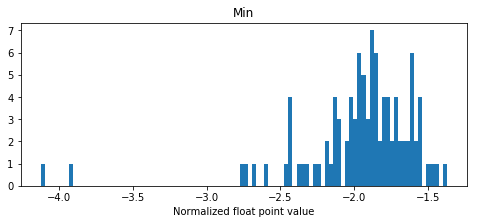

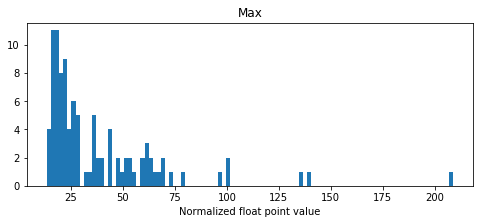

-2.0966796875 48.0703125


In [87]:
perc1s = []
perc99s = []
for section in metadata_cache['valid_sections'][stack][:100]:
    try:
        q = load_data(DataManager.get_intensity_normalization_result_filepath(what='float_percentiles', stack=stack, section=section))
    #     print q[0], q[1], q[2], q[98], q[99], q[100]
    #     perc1s.append(q[1])
    #     perc99s.append(q[99])
        perc1s.append(q[0])
        perc99s.append(q[100])
    except:
        pass
    
plt.figure(figsize=(8,3));
plt.hist(perc1s, bins=100);
plt.title('Min');
plt.xlabel('Normalized float point value');
plt.show();

plt.figure(figsize=(8,3));
plt.hist(perc99s, bins=100);
plt.title('Max');
plt.xlabel('Normalized float point value');
plt.show();

print np.percentile(perc1s, 25), np.percentile(perc99s, 75)

In [3]:
# stack = 'CHATM3'
stack = 'MD661'

for section in metadata_cache['valid_sections'][stack][:1]:
# for section in [279]:

    print section
    
    img_normalized = load_data(
              DataManager.get_intensity_normalization_result_filepath(what='normalized_float_map', stack=stack, section=section),
             download_s3=False)
        
    t = time.time()
    img_normalized_uint8 = rescale_intensity_v2(img_normalized, -2., 50.)
    sys.stderr.write('Rescale to uint8: %.2f seconds.\n' % (time.time() - t))

    t = time.time()
    raw_mask = load_data(DataManager.get_image_filepath_v2(stack=stack, prep_id=None, section=section, version='mask', resol='raw', ext='bp'),
                        download_s3=False)
    img_normalized_uint8[~raw_mask] = 0
    sys.stderr.write('Load mask: %.2f seconds.\n' % (time.time() - t))
    
    t = time.time()
    save_data(img_normalized_uint8, DataManager.get_image_filepath_v2(stack=stack, prep_id=None, section=section, version='NtbNormalizedAdaptive', resol='raw'),
             upload_s3=False)
    sys.stderr.write('Save uint8 version: %.2f seconds.\n' % (time.time() - t))

85


Rescale to uint8: 13.67 seconds.
Load mask: 0.93 seconds.
Save uint8 version: 2.39 seconds.


In [9]:
img_normalized_uint8 = \
DataManager.load_image_v2(stack=stack, prep_id=None, section=279, version='NtbNormalizedAdaptive', resol='raw')

Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_raw_NtbNormalizedAdaptive/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_raw_NtbNormalizedAdaptive.tif


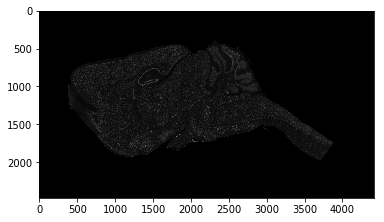

In [11]:
plt.imshow(img_normalized_uint8[::10, ::10], cmap=plt.cm.gray);

In [105]:
img = 255 - img_normalized_uint8[1000*10:2000*10, 3000*10:4000*10]

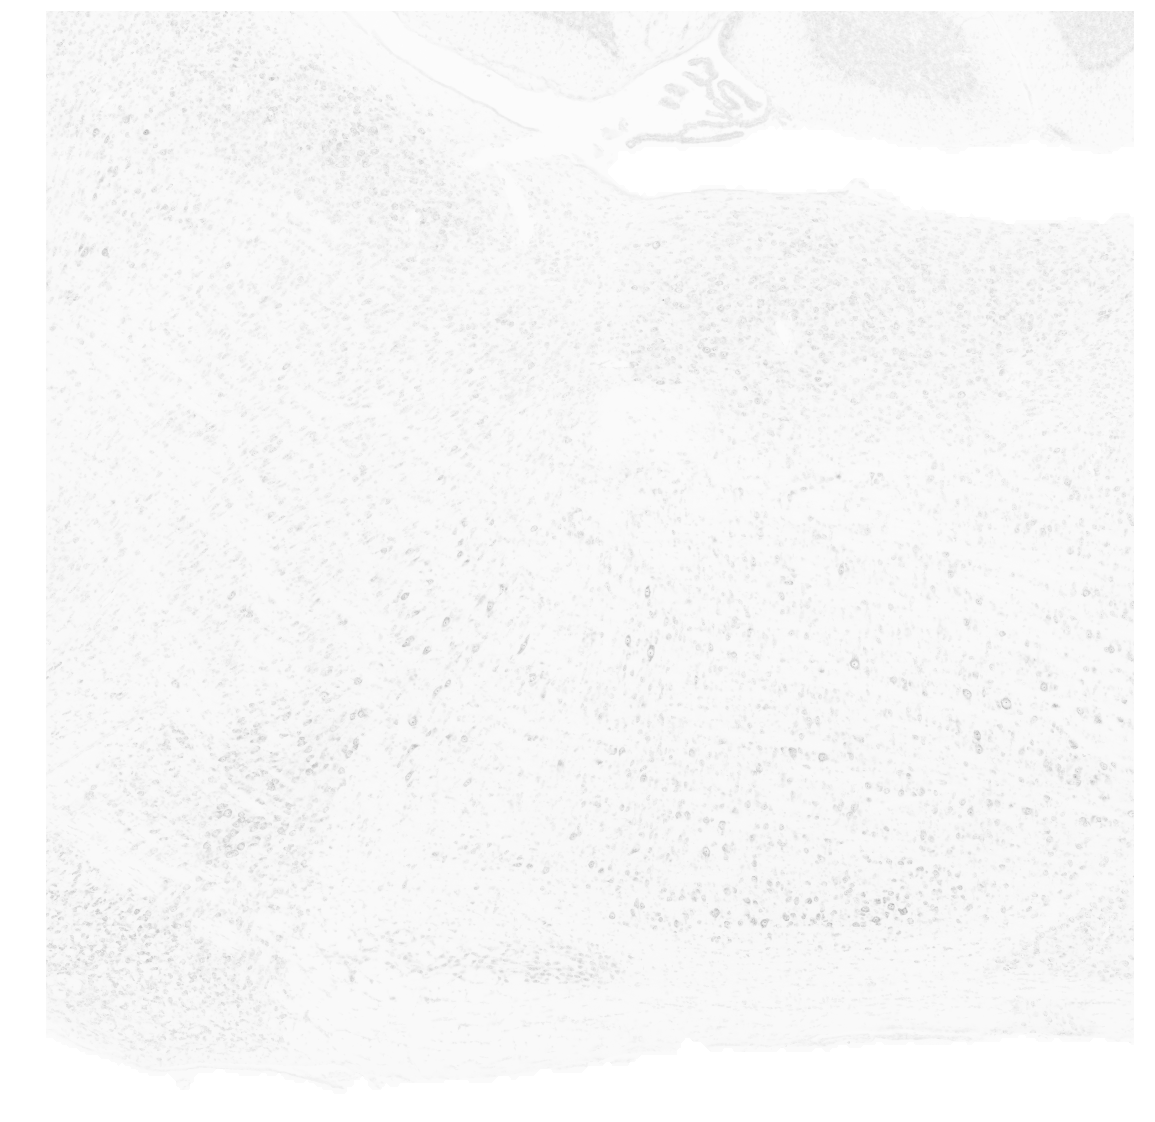

In [106]:
plt.figure(figsize=(20, 20));
plt.imshow(img, vmin=0, vmax=255, cmap=plt.cm.gray);
plt.axis('off');

In [4]:
gamma_map = img_as_ubyte(adjust_gamma(np.arange(0, 256, 1) / 255., 8.))

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


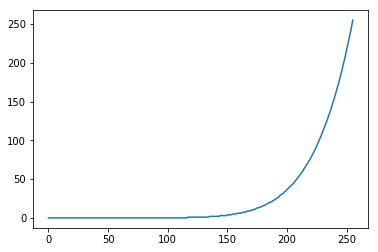

In [96]:
plt.plot(gamma_map);

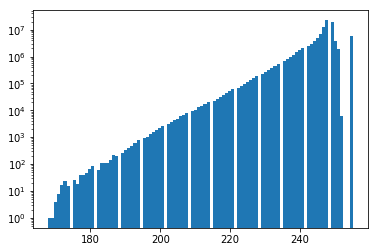

In [107]:
plt.hist(img.flatten(), bins=100, log=True);

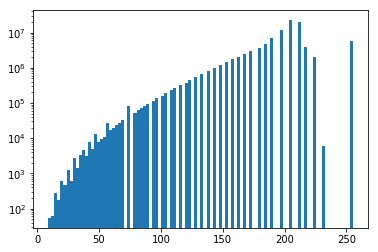

In [108]:
plt.hist(gamma_map[img].flatten(), bins=100, log=True);

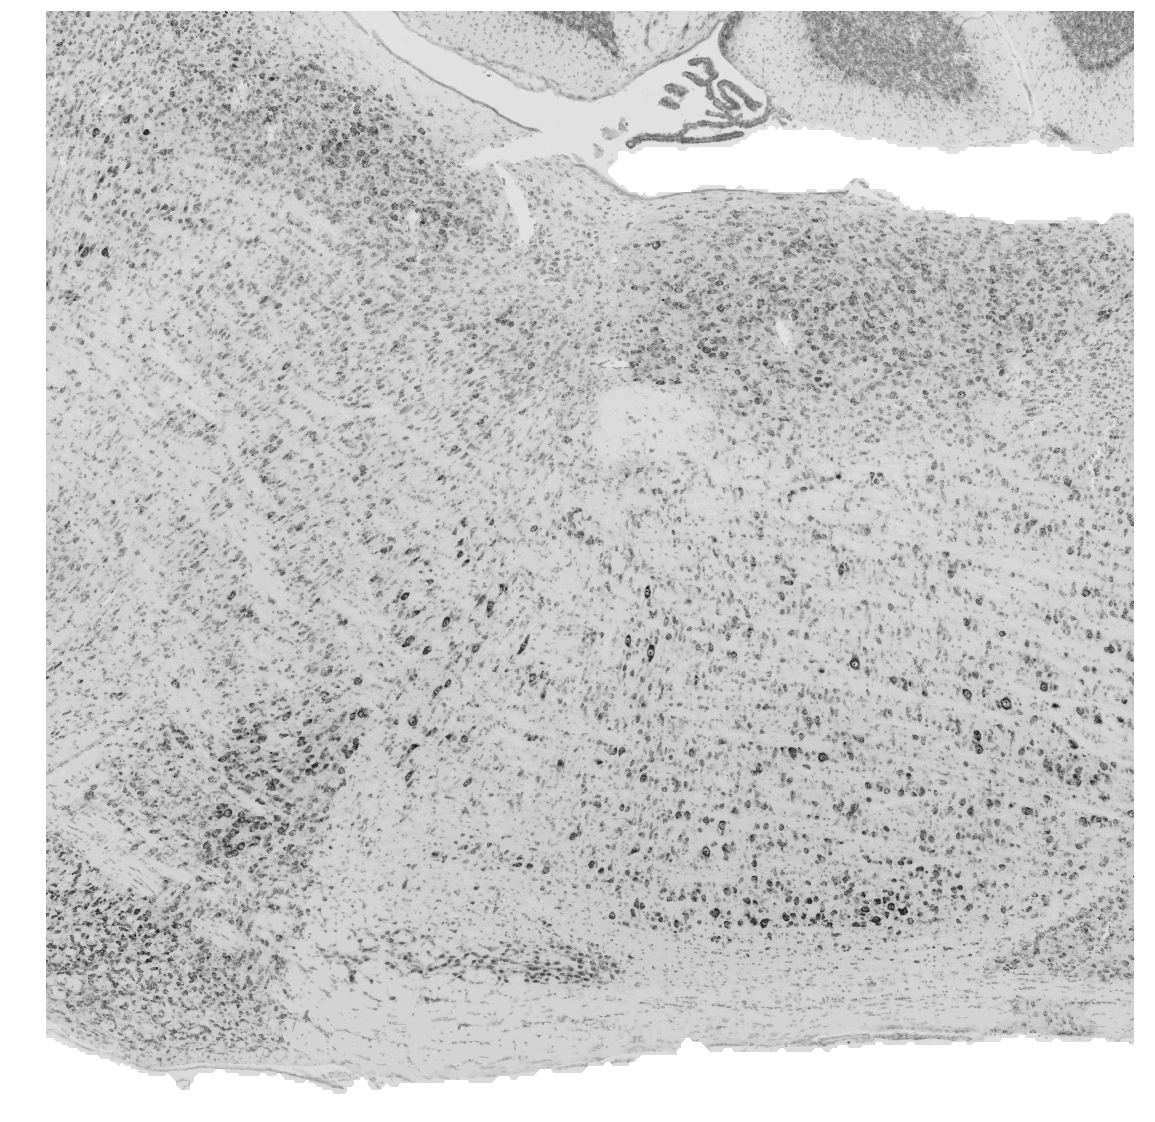

In [109]:
plt.figure(figsize=(20, 20));
plt.imshow(gamma_map[img], vmin=0, vmax=255, cmap=plt.cm.gray);
plt.axis('off');

In [5]:
gamma_map = img_as_ubyte(adjust_gamma(np.arange(0, 256, 1) / 255., 8.))

In [6]:
# stack = 'CHATM2'
stack = 'MD661'

for section in metadata_cache['valid_sections'][stack][:1]:
# for section in [279]:
    
    img_normalized_uint8 = \
    DataManager.load_image_v2(stack=stack, prep_id=None, section=section, version='NtbNormalizedAdaptive', resol='raw')
    img = 255 - img_normalized_uint8
    save_data(gamma_map[img], 
              DataManager.get_image_filepath_v2(stack=stack, prep_id=None, section=section, version='NtbNormalizedAdaptiveInvertedGamma', resol='raw'),
             upload_s3=False)

Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_raw_NtbNormalizedAdaptive/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_raw_NtbNormalizedAdaptive.tif


# Last two steps together

In [4]:
gamma_map = img_as_ubyte(adjust_gamma(np.arange(0, 256, 1) / 255., 8.))

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [5]:
# stack = 'CHATM3'
stack = 'MD662'

for section in metadata_cache['valid_sections'][stack]:
# for section in [279]:

    print section
    
    img_normalized = load_data(
              DataManager.get_intensity_normalization_result_filepath(what='normalized_float_map', stack=stack, section=section),
             download_s3=False)
        
    t = time.time()
    img_normalized_uint8 = rescale_intensity_v2(img_normalized, -2., 50.)
    sys.stderr.write('Rescale to uint8: %.2f seconds.\n' % (time.time() - t))

    t = time.time()
    raw_mask = load_data(DataManager.get_image_filepath_v2(stack=stack, prep_id=None, section=section, version='mask', resol='raw', ext='bp'),
                        download_s3=False)
    img_normalized_uint8[~raw_mask] = 0
    sys.stderr.write('Load mask: %.2f seconds.\n' % (time.time() - t))
    
#     t = time.time()
#     save_data(img_normalized_uint8, DataManager.get_image_filepath_v2(stack=stack, prep_id=None, section=section, version='NtbNormalizedAdaptive', resol='raw'),
#              upload_s3=False)
#     sys.stderr.write('Save uint8 version: %.2f seconds.\n' % (time.time() - t))
    
#     img_normalized_uint8 = \
#     DataManager.load_image_v2(stack=stack, prep_id=None, section=section, version='NtbNormalizedAdaptive', resol='raw')
    img = 255 - img_normalized_uint8
    save_data(gamma_map[img], 
              DataManager.get_image_filepath_v2(stack=stack, prep_id=None, section=section, version='NtbNormalizedAdaptiveInvertedGamma', resol='raw'),
             upload_s3=False)

100


Rescale to uint8: 21.64 seconds.
Load mask: 1.29 seconds.


101


Rescale to uint8: 27.04 seconds.
Load mask: 1.76 seconds.


102


Rescale to uint8: 28.21 seconds.
Load mask: 1.65 seconds.


103


Rescale to uint8: 21.17 seconds.
Load mask: 1.32 seconds.


104


Rescale to uint8: 23.76 seconds.
Load mask: 1.54 seconds.


105


Rescale to uint8: 22.18 seconds.
Load mask: 1.40 seconds.


106


Rescale to uint8: 25.05 seconds.
Load mask: 1.78 seconds.


107


Rescale to uint8: 23.49 seconds.
Load mask: 1.24 seconds.


108


Rescale to uint8: 19.40 seconds.
Load mask: 1.20 seconds.


109


Rescale to uint8: 20.38 seconds.
Load mask: 1.50 seconds.


110


Rescale to uint8: 22.53 seconds.
Load mask: 1.34 seconds.


111


Rescale to uint8: 18.53 seconds.
Load mask: 1.43 seconds.


112


Rescale to uint8: 20.76 seconds.
Load mask: 1.05 seconds.


113


Rescale to uint8: 19.62 seconds.
Load mask: 1.42 seconds.


114


Rescale to uint8: 23.87 seconds.
Load mask: 1.59 seconds.


115


Rescale to uint8: 24.89 seconds.
Load mask: 2.00 seconds.


116


Rescale to uint8: 26.65 seconds.
Load mask: 2.03 seconds.


117


Rescale to uint8: 25.05 seconds.
Load mask: 1.54 seconds.


118


Rescale to uint8: 20.53 seconds.
Load mask: 1.46 seconds.


119


Rescale to uint8: 19.13 seconds.
Load mask: 1.34 seconds.


120


Rescale to uint8: 24.10 seconds.
Load mask: 1.84 seconds.


121


Rescale to uint8: 23.66 seconds.
Load mask: 1.83 seconds.


122


Rescale to uint8: 24.08 seconds.
Load mask: 1.34 seconds.


123


Rescale to uint8: 23.17 seconds.
Load mask: 1.57 seconds.


124


Rescale to uint8: 23.43 seconds.
Load mask: 1.65 seconds.


125


Rescale to uint8: 26.96 seconds.
Load mask: 1.72 seconds.


126


Rescale to uint8: 24.08 seconds.
Load mask: 2.44 seconds.


127


Rescale to uint8: 23.89 seconds.
Load mask: 1.22 seconds.


128


Rescale to uint8: 28.21 seconds.
Load mask: 1.88 seconds.


129


Rescale to uint8: 25.30 seconds.
Load mask: 1.87 seconds.


130


Rescale to uint8: 29.48 seconds.
Load mask: 2.30 seconds.


131


Rescale to uint8: 29.81 seconds.
Load mask: 1.98 seconds.


132


Rescale to uint8: 32.92 seconds.
Load mask: 2.30 seconds.


133


Rescale to uint8: 23.27 seconds.
Load mask: 1.41 seconds.


134


Rescale to uint8: 22.86 seconds.
Load mask: 1.67 seconds.


135


Rescale to uint8: 22.79 seconds.
Load mask: 1.28 seconds.


136


Rescale to uint8: 24.71 seconds.
Load mask: 1.67 seconds.


137


Rescale to uint8: 25.63 seconds.
Load mask: 1.65 seconds.


138


Rescale to uint8: 21.96 seconds.
Load mask: 1.44 seconds.


139


Rescale to uint8: 20.52 seconds.
Load mask: 1.60 seconds.


140


Rescale to uint8: 27.00 seconds.
Load mask: 1.89 seconds.


141


Rescale to uint8: 24.54 seconds.
Load mask: 1.72 seconds.


142


Rescale to uint8: 20.97 seconds.
Load mask: 1.45 seconds.


143


Rescale to uint8: 20.53 seconds.
Load mask: 1.43 seconds.


144


Rescale to uint8: 22.26 seconds.
Load mask: 1.53 seconds.


145


Rescale to uint8: 23.14 seconds.
Load mask: 1.43 seconds.


146


Rescale to uint8: 24.22 seconds.
Load mask: 2.27 seconds.


147


Rescale to uint8: 21.99 seconds.
Load mask: 1.36 seconds.


148


Rescale to uint8: 27.67 seconds.
Load mask: 2.06 seconds.


149


Rescale to uint8: 27.97 seconds.
Load mask: 1.77 seconds.


150


Rescale to uint8: 32.56 seconds.
Load mask: 2.51 seconds.


151


Rescale to uint8: 26.22 seconds.
Load mask: 1.74 seconds.


152


Rescale to uint8: 23.89 seconds.
Load mask: 1.82 seconds.


153


Rescale to uint8: 23.82 seconds.
Load mask: 1.87 seconds.


154


Rescale to uint8: 23.76 seconds.
Load mask: 1.26 seconds.


155


Rescale to uint8: 24.47 seconds.
Load mask: 1.89 seconds.


156


Rescale to uint8: 24.00 seconds.
Load mask: 1.65 seconds.


157


Rescale to uint8: 22.99 seconds.
Load mask: 1.68 seconds.


158


Rescale to uint8: 26.11 seconds.
Load mask: 1.66 seconds.


159


Rescale to uint8: 22.11 seconds.
Load mask: 1.86 seconds.


160


Rescale to uint8: 18.77 seconds.
Load mask: 1.38 seconds.


161


Rescale to uint8: 21.13 seconds.
Load mask: 1.46 seconds.


162


Rescale to uint8: 21.12 seconds.
Load mask: 1.59 seconds.


163


Rescale to uint8: 20.21 seconds.
Load mask: 1.39 seconds.


164


Rescale to uint8: 24.22 seconds.
Load mask: 1.76 seconds.


165


Rescale to uint8: 22.26 seconds.
Load mask: 1.52 seconds.


166


Rescale to uint8: 27.49 seconds.
Load mask: 1.80 seconds.


167


Rescale to uint8: 26.08 seconds.
Load mask: 2.25 seconds.


168


Rescale to uint8: 17.76 seconds.
Load mask: 1.19 seconds.


169


Rescale to uint8: 22.41 seconds.
Load mask: 1.48 seconds.


170


Rescale to uint8: 23.71 seconds.
Load mask: 1.94 seconds.


171


Rescale to uint8: 18.91 seconds.
Load mask: 1.51 seconds.


172


Rescale to uint8: 20.83 seconds.
Load mask: 1.54 seconds.


173


Rescale to uint8: 25.67 seconds.
Load mask: 1.80 seconds.


174


Rescale to uint8: 23.76 seconds.
Load mask: 1.93 seconds.


175


Rescale to uint8: 18.91 seconds.
Load mask: 1.39 seconds.


176


Rescale to uint8: 23.20 seconds.
Load mask: 1.45 seconds.


177


Rescale to uint8: 20.11 seconds.
Load mask: 1.54 seconds.


178


Rescale to uint8: 20.66 seconds.
Load mask: 1.65 seconds.


179


Rescale to uint8: 20.69 seconds.
Load mask: 1.28 seconds.


180


Rescale to uint8: 21.94 seconds.
Load mask: 1.50 seconds.


181


Rescale to uint8: 16.03 seconds.
Load mask: 1.16 seconds.


182


Rescale to uint8: 20.56 seconds.
Load mask: 1.61 seconds.


183


Rescale to uint8: 21.45 seconds.
Load mask: 1.26 seconds.


184


Rescale to uint8: 17.77 seconds.
Load mask: 1.15 seconds.


185


Rescale to uint8: 18.66 seconds.
Load mask: 1.13 seconds.


186


Rescale to uint8: 24.66 seconds.
Load mask: 1.63 seconds.


187


Rescale to uint8: 18.23 seconds.
Load mask: 1.16 seconds.


188


Rescale to uint8: 20.75 seconds.
Load mask: 1.63 seconds.


189


Rescale to uint8: 20.71 seconds.
Load mask: 1.30 seconds.


190


Rescale to uint8: 18.02 seconds.
Load mask: 1.07 seconds.


191


Rescale to uint8: 23.31 seconds.
Load mask: 1.74 seconds.


192


Rescale to uint8: 22.47 seconds.
Load mask: 1.52 seconds.


193


Rescale to uint8: 21.60 seconds.
Load mask: 1.79 seconds.


194


Rescale to uint8: 26.61 seconds.
Load mask: 1.81 seconds.


195


Rescale to uint8: 19.94 seconds.
Load mask: 1.37 seconds.


196


Rescale to uint8: 18.94 seconds.
Load mask: 1.23 seconds.


197


Rescale to uint8: 24.54 seconds.
Load mask: 1.38 seconds.


198


Rescale to uint8: 22.24 seconds.
Load mask: 1.40 seconds.


199


Rescale to uint8: 18.21 seconds.
Load mask: 0.89 seconds.


200


Rescale to uint8: 25.00 seconds.
Load mask: 1.68 seconds.


201


Rescale to uint8: 24.05 seconds.
Load mask: 1.86 seconds.


202


Rescale to uint8: 30.49 seconds.
Load mask: 2.44 seconds.


203


Rescale to uint8: 31.93 seconds.
Load mask: 2.33 seconds.


204


Rescale to uint8: 29.86 seconds.
Load mask: 1.90 seconds.


205


Rescale to uint8: 28.39 seconds.
Load mask: 1.96 seconds.


206


Rescale to uint8: 33.80 seconds.
Load mask: 2.55 seconds.


207


Rescale to uint8: 32.60 seconds.
Load mask: 2.16 seconds.


208


Rescale to uint8: 30.24 seconds.
Load mask: 2.09 seconds.


209


Rescale to uint8: 33.89 seconds.
Load mask: 2.16 seconds.


210


Rescale to uint8: 31.20 seconds.
Load mask: 1.95 seconds.


211


Rescale to uint8: 30.70 seconds.
Load mask: 2.00 seconds.


212


Rescale to uint8: 36.24 seconds.
Load mask: 2.04 seconds.


213


Rescale to uint8: 34.61 seconds.
Load mask: 2.79 seconds.


214


Rescale to uint8: 34.45 seconds.
Load mask: 2.79 seconds.


215


Rescale to uint8: 29.98 seconds.
Load mask: 2.06 seconds.


216


Rescale to uint8: 27.69 seconds.
Load mask: 2.10 seconds.


217


Rescale to uint8: 33.29 seconds.
Load mask: 1.91 seconds.


218


Rescale to uint8: 34.56 seconds.
Load mask: 2.35 seconds.


219


Rescale to uint8: 31.14 seconds.
Load mask: 1.80 seconds.


220


Rescale to uint8: 35.35 seconds.
Load mask: 2.25 seconds.


221


Rescale to uint8: 33.96 seconds.
Load mask: 2.51 seconds.


222


Rescale to uint8: 31.67 seconds.
Load mask: 2.56 seconds.


223


Rescale to uint8: 33.14 seconds.
Load mask: 1.88 seconds.


224


Rescale to uint8: 32.93 seconds.
Load mask: 2.20 seconds.


225


Rescale to uint8: 32.26 seconds.
Load mask: 2.30 seconds.


226


Rescale to uint8: 33.43 seconds.
Load mask: 2.00 seconds.


227


Rescale to uint8: 34.34 seconds.
Load mask: 2.09 seconds.


228


Rescale to uint8: 33.59 seconds.
Load mask: 2.00 seconds.


229


Rescale to uint8: 30.75 seconds.
Load mask: 2.15 seconds.


230


Rescale to uint8: 29.03 seconds.
Load mask: 1.75 seconds.


231


Rescale to uint8: 33.10 seconds.
Load mask: 2.02 seconds.


232


Rescale to uint8: 34.05 seconds.
Load mask: 2.86 seconds.


233


Rescale to uint8: 29.78 seconds.
Load mask: 1.80 seconds.


234


Rescale to uint8: 31.16 seconds.
Load mask: 2.11 seconds.


235


Rescale to uint8: 32.95 seconds.
Load mask: 2.10 seconds.


236


Rescale to uint8: 32.53 seconds.
Load mask: 2.00 seconds.


237


Rescale to uint8: 33.76 seconds.
Load mask: 2.18 seconds.


238


Rescale to uint8: 32.38 seconds.
Load mask: 2.23 seconds.


239


Rescale to uint8: 33.62 seconds.
Load mask: 1.94 seconds.


240


Rescale to uint8: 31.72 seconds.
Load mask: 2.48 seconds.


241


Rescale to uint8: 38.53 seconds.
Load mask: 2.26 seconds.


242


Rescale to uint8: 37.49 seconds.
Load mask: 2.03 seconds.


243


Rescale to uint8: 35.15 seconds.
Load mask: 2.08 seconds.


244


Rescale to uint8: 27.09 seconds.
Load mask: 1.65 seconds.


245


Rescale to uint8: 32.76 seconds.
Load mask: 2.05 seconds.


246


Rescale to uint8: 30.71 seconds.
Load mask: 1.92 seconds.


247


Rescale to uint8: 33.25 seconds.
Load mask: 2.68 seconds.


248


Rescale to uint8: 30.96 seconds.
Load mask: 2.09 seconds.


249


Rescale to uint8: 35.60 seconds.
Load mask: 2.56 seconds.


250


Rescale to uint8: 32.78 seconds.
Load mask: 2.46 seconds.


251


Rescale to uint8: 35.52 seconds.
Load mask: 2.18 seconds.


252


Rescale to uint8: 35.07 seconds.
Load mask: 2.49 seconds.


253


Rescale to uint8: 34.11 seconds.
Load mask: 2.66 seconds.


254


Rescale to uint8: 32.90 seconds.
Load mask: 2.25 seconds.


255


Rescale to uint8: 32.98 seconds.
Load mask: 1.90 seconds.


256


Rescale to uint8: 30.74 seconds.
Load mask: 2.39 seconds.


257


Rescale to uint8: 31.13 seconds.
Load mask: 2.38 seconds.


258


Rescale to uint8: 30.51 seconds.
Load mask: 2.05 seconds.


259


Rescale to uint8: 30.86 seconds.
Load mask: 2.17 seconds.


260


Rescale to uint8: 26.74 seconds.
Load mask: 1.52 seconds.


261


Rescale to uint8: 30.57 seconds.
Load mask: 1.79 seconds.


262


Rescale to uint8: 31.62 seconds.
Load mask: 2.51 seconds.


263


Rescale to uint8: 31.74 seconds.
Load mask: 2.03 seconds.


264


Rescale to uint8: 32.23 seconds.
Load mask: 2.14 seconds.


265


Rescale to uint8: 31.22 seconds.
Load mask: 2.15 seconds.


266


Rescale to uint8: 30.90 seconds.
Load mask: 2.40 seconds.


267


Rescale to uint8: 30.90 seconds.
Load mask: 2.33 seconds.


268


Rescale to uint8: 31.68 seconds.
Load mask: 2.16 seconds.


269


Rescale to uint8: 28.35 seconds.
Load mask: 2.13 seconds.


270


Rescale to uint8: 33.20 seconds.
Load mask: 2.44 seconds.


271


Rescale to uint8: 31.87 seconds.
Load mask: 1.96 seconds.


272


Rescale to uint8: 31.07 seconds.
Load mask: 2.01 seconds.


273


Rescale to uint8: 32.77 seconds.
Load mask: 1.95 seconds.


274


Rescale to uint8: 31.03 seconds.
Load mask: 2.17 seconds.


275


Rescale to uint8: 30.26 seconds.
Load mask: 2.31 seconds.


276


Rescale to uint8: 31.62 seconds.
Load mask: 2.52 seconds.


277


Rescale to uint8: 31.62 seconds.
Load mask: 2.35 seconds.


278


Rescale to uint8: 34.98 seconds.
Load mask: 2.48 seconds.


279


Rescale to uint8: 30.34 seconds.
Load mask: 1.76 seconds.


280


Rescale to uint8: 28.84 seconds.
Load mask: 2.00 seconds.


281


Rescale to uint8: 32.05 seconds.
Load mask: 2.18 seconds.


282


Rescale to uint8: 27.77 seconds.
Load mask: 1.69 seconds.


283


Rescale to uint8: 30.42 seconds.
Load mask: 2.16 seconds.


284


Rescale to uint8: 25.20 seconds.
Load mask: 2.02 seconds.


285


Rescale to uint8: 30.50 seconds.
Load mask: 1.89 seconds.


286


Rescale to uint8: 34.91 seconds.
Load mask: 2.65 seconds.


287


Rescale to uint8: 31.39 seconds.
Load mask: 2.63 seconds.


288


Rescale to uint8: 31.24 seconds.
Load mask: 1.70 seconds.


289


Rescale to uint8: 30.22 seconds.
Load mask: 1.92 seconds.


290


Rescale to uint8: 31.23 seconds.
Load mask: 1.97 seconds.


291


Rescale to uint8: 29.85 seconds.
Load mask: 2.09 seconds.


292


Rescale to uint8: 33.30 seconds.
Load mask: 2.15 seconds.


293


Rescale to uint8: 37.52 seconds.
Load mask: 2.69 seconds.


294


Rescale to uint8: 31.85 seconds.
Load mask: 2.53 seconds.


295


Rescale to uint8: 35.62 seconds.
Load mask: 2.07 seconds.


296


Rescale to uint8: 37.54 seconds.
Load mask: 2.83 seconds.


297


Rescale to uint8: 37.81 seconds.
Load mask: 2.22 seconds.


298


Rescale to uint8: 31.70 seconds.
Load mask: 1.96 seconds.


299


Rescale to uint8: 31.88 seconds.
Load mask: 2.15 seconds.


300


Rescale to uint8: 34.41 seconds.
Load mask: 2.82 seconds.


301


Rescale to uint8: 38.26 seconds.
Load mask: 2.12 seconds.


302


Rescale to uint8: 35.80 seconds.
Load mask: 1.98 seconds.


303


Rescale to uint8: 34.56 seconds.
Load mask: 2.35 seconds.


304


Rescale to uint8: 31.19 seconds.
Load mask: 2.43 seconds.


305


Rescale to uint8: 31.94 seconds.
Load mask: 2.40 seconds.


306


Rescale to uint8: 26.42 seconds.
Load mask: 2.08 seconds.


307


Rescale to uint8: 24.65 seconds.
Load mask: 1.66 seconds.


308


Rescale to uint8: 31.44 seconds.
Load mask: 2.55 seconds.


309


Rescale to uint8: 38.88 seconds.
Load mask: 2.13 seconds.


310


Rescale to uint8: 36.97 seconds.
Load mask: 2.55 seconds.


311


Rescale to uint8: 34.38 seconds.
Load mask: 2.28 seconds.


312


Rescale to uint8: 22.72 seconds.
Load mask: 1.56 seconds.


313


Rescale to uint8: 27.16 seconds.
Load mask: 2.45 seconds.


314


Rescale to uint8: 27.30 seconds.
Load mask: 2.44 seconds.


315


Rescale to uint8: 29.42 seconds.
Load mask: 1.83 seconds.


316


Rescale to uint8: 22.85 seconds.
Load mask: 1.83 seconds.


317


Rescale to uint8: 26.72 seconds.
Load mask: 1.74 seconds.


318


Rescale to uint8: 27.87 seconds.
Load mask: 2.07 seconds.


319


Rescale to uint8: 20.93 seconds.
Load mask: 1.76 seconds.


320


Rescale to uint8: 24.71 seconds.
Load mask: 1.72 seconds.


321


Rescale to uint8: 25.99 seconds.
Load mask: 2.33 seconds.


322


Rescale to uint8: 20.73 seconds.
Load mask: 1.47 seconds.


323


Rescale to uint8: 22.45 seconds.
Load mask: 1.63 seconds.


324


Rescale to uint8: 20.68 seconds.
Load mask: 1.79 seconds.


325


Rescale to uint8: 23.17 seconds.
Load mask: 1.33 seconds.


326


Rescale to uint8: 21.28 seconds.
Load mask: 1.29 seconds.


327


Rescale to uint8: 25.73 seconds.
Load mask: 2.17 seconds.


328


Rescale to uint8: 21.04 seconds.
Load mask: 1.26 seconds.


329


Rescale to uint8: 22.85 seconds.
Load mask: 2.00 seconds.


330


Rescale to uint8: 27.00 seconds.
Load mask: 1.96 seconds.


331


Rescale to uint8: 20.85 seconds.
Load mask: 1.68 seconds.


332


Rescale to uint8: 25.92 seconds.
Load mask: 1.55 seconds.


333


Rescale to uint8: 23.69 seconds.
Load mask: 1.47 seconds.


334


Rescale to uint8: 20.54 seconds.
Load mask: 1.72 seconds.


335


Rescale to uint8: 24.95 seconds.
Load mask: 1.86 seconds.


336


Rescale to uint8: 24.56 seconds.
Load mask: 1.66 seconds.


337


Rescale to uint8: 21.28 seconds.
Load mask: 1.39 seconds.


338


Rescale to uint8: 21.45 seconds.
Load mask: 1.25 seconds.


339


Rescale to uint8: 23.64 seconds.
Load mask: 1.56 seconds.


340


Rescale to uint8: 22.99 seconds.
Load mask: 1.43 seconds.


341


Rescale to uint8: 21.66 seconds.
Load mask: 1.28 seconds.


342


Rescale to uint8: 21.71 seconds.
Load mask: 1.66 seconds.


343


Rescale to uint8: 18.21 seconds.
Load mask: 1.36 seconds.


344


Rescale to uint8: 19.97 seconds.
Load mask: 1.20 seconds.


345


Rescale to uint8: 20.66 seconds.
Load mask: 1.19 seconds.


346


Rescale to uint8: 22.73 seconds.
Load mask: 1.31 seconds.


347


Rescale to uint8: 24.81 seconds.
Load mask: 1.84 seconds.


348


Rescale to uint8: 22.45 seconds.
Load mask: 1.56 seconds.


349


Rescale to uint8: 19.64 seconds.
Load mask: 1.16 seconds.


350


Rescale to uint8: 21.38 seconds.
Load mask: 1.39 seconds.


351


Rescale to uint8: 23.56 seconds.
Load mask: 1.36 seconds.


352


Rescale to uint8: 20.05 seconds.
Load mask: 1.22 seconds.


353


Rescale to uint8: 20.56 seconds.
Load mask: 1.70 seconds.


354


Rescale to uint8: 21.12 seconds.
Load mask: 1.68 seconds.


355


Rescale to uint8: 21.35 seconds.
Load mask: 1.49 seconds.


356


Rescale to uint8: 22.45 seconds.
Load mask: 1.65 seconds.


357


Rescale to uint8: 20.10 seconds.
Load mask: 1.31 seconds.


358


Rescale to uint8: 23.79 seconds.
Load mask: 1.55 seconds.


359


Rescale to uint8: 26.48 seconds.
Load mask: 2.19 seconds.


360


Rescale to uint8: 22.39 seconds.
Load mask: 1.83 seconds.


361


Rescale to uint8: 24.63 seconds.
Load mask: 1.96 seconds.


362


Rescale to uint8: 22.06 seconds.
Load mask: 1.66 seconds.


363


Rescale to uint8: 20.96 seconds.
Load mask: 1.33 seconds.


364


Rescale to uint8: 18.41 seconds.
Load mask: 1.23 seconds.


365


Rescale to uint8: 18.63 seconds.
Load mask: 1.36 seconds.


366


Rescale to uint8: 17.96 seconds.
Load mask: 1.23 seconds.


367


Rescale to uint8: 18.97 seconds.
Load mask: 1.39 seconds.


368


Rescale to uint8: 17.23 seconds.
Load mask: 1.18 seconds.


369


Rescale to uint8: 18.80 seconds.
Load mask: 1.10 seconds.


370


Rescale to uint8: 18.20 seconds.
Load mask: 1.41 seconds.


371


Rescale to uint8: 16.48 seconds.
Load mask: 1.32 seconds.


372


Rescale to uint8: 17.00 seconds.
Load mask: 1.33 seconds.


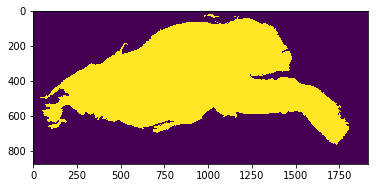

In [7]:
plt.imshow(tb_mask);

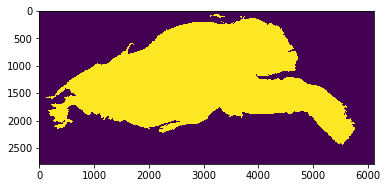

In [39]:
plt.imshow(raw_mask[::10, ::10]);

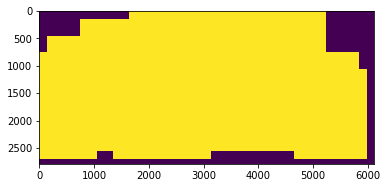

In [40]:
plt.imshow(std_map[::10, ::10] > 0)

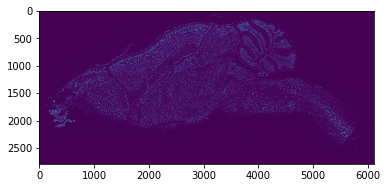

In [41]:
plt.imshow(img[::10, ::10]);

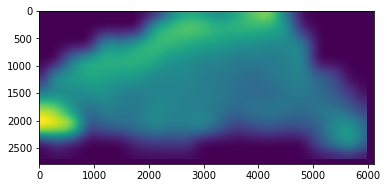

In [42]:
plt.imshow(mean_map[::10, ::10]);
# plt.colorbar();

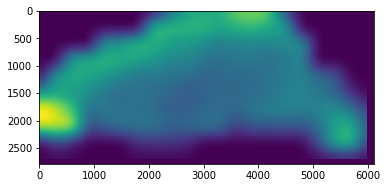

In [43]:
plt.imshow(std_map[::10, ::10]);
# plt.colorbar();

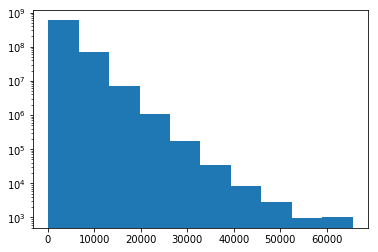

In [48]:
plt.hist(img[raw_mask], log=True);

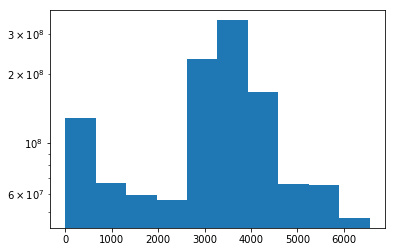

In [51]:
plt.hist(mean_map[raw_mask], log=True);

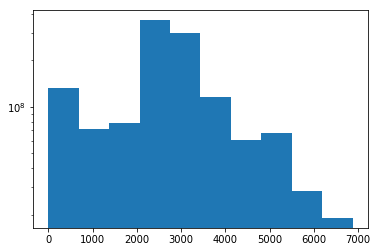

In [52]:
plt.hist(std_map[raw_mask], log=True);

In [15]:
img_normalized = np.zeros(img.shape, np.float32)
img_normalized[raw_mask] = (img[raw_mask] - mean_map[raw_mask]) / std_map[raw_mask]

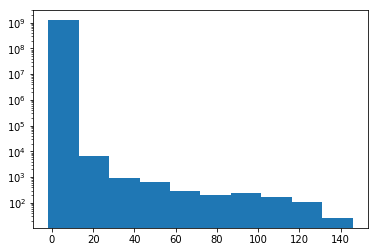

In [54]:
plt.hist(img_normalized[raw_mask], log=True);

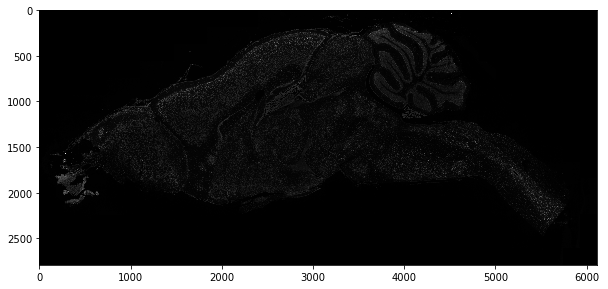

In [49]:
plt.figure(figsize=(10,10));
plt.imshow(img[::10, ::10], cmap=plt.cm.gray);

In [44]:
cx_cy_all_regions = np.array(cx_cy_all_regions)

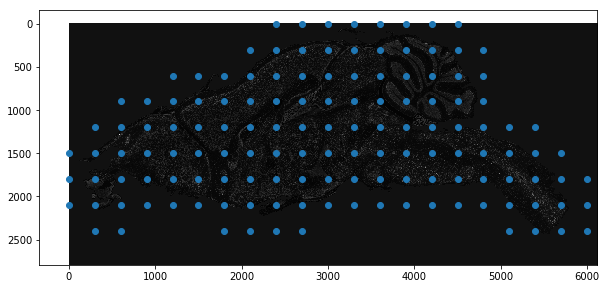

In [45]:
plt.figure(figsize=(10,10));
plt.imshow(img_normalized[::10, ::10], cmap=plt.cm.gray);
plt.scatter(cx_cy_all_regions[:,0]/10, cx_cy_all_regions[:,1]/10);

In [46]:
img_normalized_uint8 = rescale_intensity_v2(img_normalized, -1, 6)

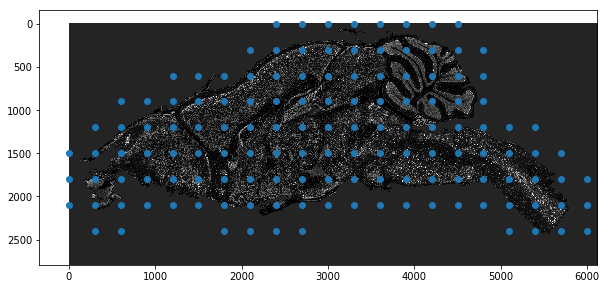

In [47]:
plt.figure(figsize=(10,10));
plt.imshow(img_normalized_uint8[::10, ::10], cmap=plt.cm.gray);
plt.scatter(cx_cy_all_regions[:,0]/10, cx_cy_all_regions[:,1]/10);